In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import the cleaned dataset
df = pd.read_csv("df_clean_ii.csv")

# Quick check
print(df.shape)
df.head()

(2200, 38)


,Client_ID,Household_Income,Kids_Count,Teens_Count,Days_Since_Last_Purchase,Spend_Wines,Spend_Fruits,Spend_Meat,Spend_Fish,Spend_Sweets,...,Marital_Together,Marital_Widow,Edu_2ndCycle,Edu_Basic,Edu_Graduation,Edu_Master,Edu_PhD,Spend_Total,Spend_RegularProducts,Total_Campaigns_Accepted
0,0,58138.0,0,0,58,635,88,546,172,88,...,0,0,0,0,1,0,0,1617,1529,0
1,1,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,0,1,0,0,27,21,0
2,2,71613.0,0,0,26,426,49,127,111,21,...,1,0,0,0,1,0,0,776,734,0
3,3,26646.0,1,0,26,11,4,20,10,3,...,1,0,0,0,1,0,0,53,48,0
4,4,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,0,0,0,1,422,407,0


## Feature Engineering

### Campaign Conversion Rates

To evaluate the performance of each marketing campaign, we calculate the **conversion rate**, defined as the percentage of customers who accepted the campaign offer.  

Steps:  
1. Identify all campaign response columns (`Campaign1_Response` … `Campaign5_Response` and `LastCampaign_Response`).  
2. Compute the **mean** of each binary response column (0 = not accepted, 1 = accepted).  
3. Multiply by 100 to obtain conversion rates in percentages.  
4. Present the results in a sorted table, highest to lowest.  

This provides a quick overview of which campaigns were most successful in terms of customer acceptance.

In [3]:
# 1) Automatically detect campaign response columns
campaign_cols = [c for c in df.columns if c.startswith("Campaign") and c.endswith("_Response")]
if "LastCampaign_Response" in df.columns:
    campaign_cols += ["LastCampaign_Response"]

if not campaign_cols:
    raise ValueError("No campaign response columns found.")

# 2) Force DataFrame selection and numeric, compute mean (%)
means = (
    df[campaign_cols]                      # DataFrame (even if 1 col)
    .apply(pd.to_numeric, errors="coerce") # ensure numeric 0/1
    .mean()                                # Series of means
    * 100
)

# 3) Build final table of conversion rates
campaign_conv = (
    pd.DataFrame({"Campaign": means.index, "Conversion_Rate": np.round(means.values, 2)})
    .sort_values("Conversion_Rate", ascending=False)
    .reset_index(drop=True)
)

display(campaign_conv)

,Campaign,Conversion_Rate
0,LastCampaign_Response,15.14
1,Campaign4_Response,7.45
2,Campaign3_Response,7.41
3,Campaign5_Response,7.32
4,Campaign1_Response,6.45
5,Campaign2_Response,1.36


### Customer Re-Engagement Rates

Re-engagement rate measures the percentage of customers who made a purchase
within a given time window since their last interaction.  

- **30-day re-engagement**: customers who returned within the last 30 days.  
- **60-day re-engagement**: customers who returned within the last 60 days.  
- **90-day re-engagement**: customers who returned within the last 90 days.  

This metric helps evaluate how quickly customers come back and how effective
our campaigns are at driving repeat purchases.

In [4]:
# Check the range of days to understand customer tenure and re-engagement windows

print("Days_Since_Became_Customer range:",
      df["Days_Since_Became_Customer"].min(),
      "to",
      df["Days_Since_Became_Customer"].max())

print("Days_Since_Last_Purchase range:",
      df["Days_Since_Last_Purchase"].min(),
      "to",
      df["Days_Since_Last_Purchase"].max())

Days_Since_Became_Customer range: 2159 to 2858
Days_Since_Last_Purchase range: 0 to 99


In [5]:
def reengagement_rate(df, days):
    """
    Calculates re-engagement rate as the % of customers who made
    a purchase within the last `days` days.
    """
    return (df["Days_Since_Last_Purchase"] <= days).mean() * 100

# Calculate re-engagement rates at 30, 60, 90 days
reengage_30 = reengagement_rate(df, 30)
reengage_60 = reengagement_rate(df, 60)
reengage_90 = reengagement_rate(df, 90)

# Display results
print(f"Overall 30d re-engagement: {reengage_30:.1f}%")
print(f"Overall 60d re-engagement: {reengage_60:.1f}%")
print(f"Overall 90d re-engagement: {reengage_90:.1f}%")

Overall 30d re-engagement: 32.3%
Overall 60d re-engagement: 61.6%
Overall 90d re-engagement: 91.2%


### RFM Feature Engineering

Three new variables were created based on the **RFM (Recency, Frequency, Monetary)** framework:

- **R (Recency):**  
  Number of days since the customer's last purchase.  
  Lower values indicate more recent activity.

- **F (Frequency):**  
  Total number of purchases across all channels (deals, web, catalog, and store).  
  Higher values reflect more frequent buyers.

- **M (Monetary):**  
  Total amount spent by the customer (`Spend_Total`).  
  Higher values correspond to higher-spending customers.

These RFM features provide a compact summary of purchasing behavior and will be useful for customer profiling, clustering, and predictive modeling.

In [6]:
# --- RFM Feature Engineering (using current column names) ---

# R (Recency): days since last purchase (lower = more recent)
df["R"] = df["Days_Since_Last_Purchase"]

# F (Frequency): total purchases across all channels
df["F"] = (
    df["Purchases_Deals"] +
    df["Purchases_Web"] +
    df["Purchases_Catalog"] +
    df["Purchases_Store"]
)

# M (Monetary): total spend (we use Spend_Total, which includes Gold per our earlier fix)
df["M"] = df["Spend_Total"]

# Quick preview
print(df[["R", "F", "M"]].head())

    R   F     M
0  58  25  1617
1  38   6    27
2  26  21   776
3  26   8    53
4  94  19   422


### RFM Segmentation (6 Categories)

RFM (Recency, Frequency, Monetary) scoring was introduced to **standardize customer behavior into comparable scales**.  
Instead of working with raw values (days, purchase counts, spend), each customer was assigned a 1–5 score for R, F, and M using quintiles.  
This makes it easier to categorize customers consistently and highlight meaningful differences.

Using these scores, customers were then grouped into six actionable categories:

- **Champions:**  
  Very recent purchasers, buy frequently, and spend the most.  

- **Loyal Customers:**  
  Strong purchase frequency and spending, though not as recent as Champions.  

- **Potential Loyalists:**  
  Recent buyers with lower purchase frequency who may become more valuable over time.  

- **At Risk:**  
  Customers who used to buy frequently but have not purchased recently.  

- **Cold Customers:**  
  Customers with poor recency and low frequency, showing declining engagement.  

- **Lost:**  
  The least engaged group with very poor recency, effectively inactive.  

This condensed framework reduces complexity while still highlighting the most important customer groups for retention, reactivation, and growth strategies.

In [7]:
# --- Step 1: Create R, F, M scores (1–5 using quintiles) ---
df["R_score"] = pd.qcut(df["R"], 5, labels=[5, 4, 3, 2, 1])  # lower R = better, so reversed
df["F_score"] = pd.qcut(df["F"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
df["M_score"] = pd.qcut(df["M"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

# Convert to numeric
df["R_score"] = df["R_score"].astype(int)
df["F_score"] = df["F_score"].astype(int)
df["M_score"] = df["M_score"].astype(int)

# --- Step 2: Define RFM-based customer segments (6 categories) ---

conditions = [
    # 1) Champions: very recent, frequent, and high spend
    (df['R_score'] >= 4) & (df['F_score'] >= 4) & (df['M_score'] >= 4),

    # 2) Loyal Customers: strong frequency & spend, reasonably recent (exclude Champions)
    (df['R_score'] >= 3) & (df['F_score'] >= 4) & (df['M_score'] >= 3) &
    ~((df['R_score'] >= 4) & (df['F_score'] >= 4) & (df['M_score'] >= 4)),

    # 3) Potential Loyalists: very recent buyers but frequency still low
    (df['R_score'] >= 4) & (df['F_score'] <= 3),

    # 4) At Risk: poor recency but used to buy frequently
    (df['R_score'] <= 2) & (df['F_score'] >= 3),

    # 5) Cold Customers: poor recency and low frequency (but not the very worst)
    (df['R_score'] == 2) & (df['F_score'] <= 2),

    # 6) Lost: very poor recency (<=1), regardless of frequency
    (df['R_score'] <= 1)
]

labels = [
    'Champions',
    'Loyal Customers',
    'Potential Loyalists',
    'At Risk',
    'Cold Customers',
    'Lost'
]

df['segment_definition'] = np.select(conditions, labels, default='Cold Customers')

# Sanity check
print(df['segment_definition'].value_counts())

segment_definition
Potential Loyalists    551
At Risk                531
Cold Customers         420
Champions              275
Loyal Customers        248
Lost                   175
Name: count, dtype: int64


### Average Order Value (AOV)

To better understand customer spending behavior, an **AOV (Average Order Value)** metric was created.  

- **Total_Purchases** was calculated by summing purchases across all channels: deals, web, catalog, and store.  
- **AOV** was then calculated as:  

\[
\text{AOV} = \frac{\text{Spend\_Total}}{\text{Total\_Purchases}}
\]

- To avoid errors, customers with zero purchases were assigned an AOV of 0.  

This new feature helps compare how much customers typically spend per order and can be useful for profiling and predictive modeling.

In [8]:
# Calculate total purchases across all channels
df["Total_Purchases"] = (
    df["Purchases_Deals"] +
    df["Purchases_Web"] +
    df["Purchases_Catalog"] +
    df["Purchases_Store"]
)

# Calculate AOV: spend per purchase
# Protect against division by zero (if no purchases, set AOV = 0)
df["AOV"] = df["Spend_Total"] / df["Total_Purchases"].replace(0, np.nan)
df["AOV"] = df["AOV"].fillna(0)

# Quick check
print(df[["Spend_Total", "Total_Purchases", "AOV"]].head())

   Spend_Total  Total_Purchases        AOV
0         1617               25  64.680000
1           27                6   4.500000
2          776               21  36.952381
3           53                8   6.625000
4          422               19  22.210526


## Feature Importance

### Feature Importance Analysis by Campaign

To understand which variables drive responses to each marketing campaign, a **Random Forest Classifier** was trained separately for Campaigns 1–5.  

**Steps performed:**
1. **Feature selection:**  
   Only numeric variables were included to avoid errors. All campaign response variables (including `LastCampaign_Response`) were excluded from the predictors to prevent target leakage.  

2. **Target variable:**  
   For each run, the model used one campaign response (e.g., `Campaign1_Response`) as the target (`y`).  

3. **Train/test split:**  
   Data was split into training (70%) and testing (30%), stratified to preserve the balance between responders (1) and non-responders (0).  

4. **Imputation:**  
   Missing values in the features were imputed using the median.  

5. **Model training:**  
   A Random Forest with 200 trees was trained, using `class_weight="balanced"` to account for class imbalance (few responders compared to non-responders).  

6. **Evaluation:**  
   A classification report (precision, recall, f1-score) was printed to measure how well the model predicts campaign responses.  

7. **Feature importance:**  
   For each campaign, the **top 15 features** were extracted and ranked by importance. These values indicate which variables most strongly influence whether a customer accepts that specific campaign.  

This approach provides a campaign-by-campaign view of the strongest predictors, allowing profiling of which customer traits (spending, income, demographics, etc.) align with campaign acceptance.

In [9]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

campaign_cols = [
    "Campaign1_Response", "Campaign2_Response", "Campaign3_Response",
    "Campaign4_Response", "Campaign5_Response"
]

# Columns to drop (engineered / redundant)
drop_cols = campaign_cols + [
    "LastCampaign_Response",   # leakage
    "R", "F", "M",             # raw RFM metrics
    "R_score", "F_score", "M_score",  # RFM score buckets
    "Total_Campaigns_Accepted", "AOV", "Spend_Total","Spend_RegularProducts","Total_Purchases",# leakage
    "Client_ID"
]

for target in campaign_cols:
    print(f"\n=== Feature Importance for {target} ===")

    # 1) Numeric features only; drop targets + redundant cols
    X_num = df.select_dtypes(include=[np.number]).copy()
    X = X_num.drop(columns=drop_cols, errors="ignore")
    y = df[target].astype(int)

    # 2) Train/test split (stratify keeps class balance)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42, stratify=y
    )

    # 3) Impute missing
    imp = SimpleImputer(strategy="median")
    X_train_imp = imp.fit_transform(X_train)
    X_test_imp  = imp.transform(X_test)

    # 4) Random Forest
    rf = RandomForestClassifier(
        n_estimators=200, random_state=42,
        class_weight="balanced", n_jobs=-1
    )
    rf.fit(X_train_imp, y_train)

    # 5) Evaluation
    y_pred = rf.predict(X_test_imp)
    print(classification_report(y_test, y_pred, digits=3))

    # 6) Feature importances (top 15)
    importances = pd.Series(
        rf.feature_importances_, index=X.columns
    ).sort_values(ascending=False)
    top15 = importances.head(15)
    print("\nTop 15 features:")
    print(top15.to_frame("importance"))


=== Feature Importance for Campaign1_Response ===
              precision    recall  f1-score   support

           0      0.950     0.995     0.972       617
           1      0.786     0.256     0.386        43

    accuracy                          0.947       660
   macro avg      0.868     0.625     0.679       660
weighted avg      0.940     0.947     0.934       660


Top 15 features:
                            importance
Household_Income              0.204861
Spend_Meat                    0.126648
Purchases_Catalog             0.098534
Spend_Wines                   0.096335
Spend_Fish                    0.058177
Spend_Fruits                  0.050925
Spend_Sweets                  0.048617
Days_Since_Became_Customer    0.039008
Purchases_Web                 0.037759
Purchases_Store               0.033212
Days_Since_Last_Purchase      0.033200
Customer_Age                  0.031726
Purchases_Deals               0.030226
Spend_Gold                    0.029928
Web_Visits_Month   

### Checking Collinearity with Correlation Matrix

To assess collinearity among features, I performed a **correlation analysis** using Pearson’s correlation coefficient:

1. **Selected numeric columns only** to avoid non-numeric data in the calculation.  
2. **Generated a full correlation matrix**, showing pairwise correlations between all numeric variables.  
3. **Identified pairs with high correlation** (absolute value |r| ≥ 0.80).  
   - The upper triangle of the matrix was used to avoid duplicate pairs.  
   - These highly correlated pairs were extracted into a list for easier review.

This process highlights features that may be redundant or strongly overlapping.  
For regression models, such multicollinearity can cause unstable coefficients, while for tree-based models the impact is less severe.

In [10]:
# Select all numeric columns
X = df.select_dtypes(include=[np.number])

# 1. Correlation matrix
corr = X.corr(method="pearson")

# 2. Print full matrix (rounded)
print("\n=== Correlation Matrix (Pearson) ===")
print(corr.round(2))

# 3. List pairs with high correlation
threshold = 0.80
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr = (
    upper.stack()
    .reset_index()
    .rename(columns={"level_0": "Feature1", "level_1": "Feature2", 0: "Correlation"})
    .query("abs(Correlation) >= @threshold")
    .sort_values(by="Correlation", key=lambda s: s.abs(), ascending=False)
)

print(f"\nHighly correlated pairs (|r| ≥ {threshold}):")
print(high_corr)


=== Correlation Matrix (Pearson) ===
                            Client_ID  Household_Income  Kids_Count  \
Client_ID                        1.00             -0.01       -0.02   
Household_Income                -0.01              1.00       -0.53   
Kids_Count                      -0.02             -0.53        1.00   
Teens_Count                      0.04              0.04       -0.04   
Days_Since_Last_Purchase        -0.00              0.01        0.01   
Spend_Wines                      0.00              0.73       -0.50   
Spend_Fruits                     0.03              0.54       -0.37   
Spend_Meat                       0.00              0.72       -0.46   
Spend_Fish                       0.01              0.56       -0.39   
Spend_Sweets                    -0.01              0.55       -0.38   
Spend_Gold                       0.01              0.42       -0.36   
Purchases_Deals                  0.02             -0.13        0.23   
Purchases_Web                    0.03  

### Highly correlated pairs (|r| ≥ 0.8)

| Feature1                  | Feature2              | Correlation |
|----------------------------|-----------------------|-------------|
| Spend_Total                | M                     | 1.000000    |
| Days_Since_Last_Purchase   | R                     | 1.000000    |
| F                          | Total_Purchases       | 1.000000    |
| Spend_RegularProducts      | M                     | 0.997098    |
| Spend_Total                | Spend_RegularProducts | 0.997098    |
| R                          | R_score               | -0.980428   |
| Days_Since_Last_Purchase   | R_score               | -0.980428   |
| F_score                    | Total_Purchases       | 0.969435    |
| F                          | F_score               | 0.969435    |
| M                          | AOV                   | 0.932811    |
| Spend_Total                | AOV                   | 0.932811    |
| Spend_RegularProducts      | AOV                   | 0.929702    |
| M                          | M_score               | 0.919830    |
| Spend_Total                | M_score               | 0.919830    |
| Spend_RegularProducts      | M_score               | 0.911540    |
| Spend_Wines                | Spend_RegularProducts | 0.904862    |
| Spend_Wines                | M                     | 0.899589    |
| Spend_Wines                | Spend_Total           | 0.899589    |
| Spend_Meat                 | Spend_RegularProducts | 0.865811    |
| Spend_Meat                 | M                     | 0.861703    |
| Spend_Meat                 | Spend_Total           | 0.861703    |
| M_score                    | AOV                   | 0.852899    |
| M_score                    | Total_Purchases       | 0.852045    |
| F                          | M_score               | 0.852045    |
| F_score                    | M_score               | 0.851136    |
| Purchases_Store            | F                     | 0.842345    |
| Purchases_Store            | Total_Purchases       | 0.842345    |
| Household_Income           | M_score               | 0.838579    |
| Spend_Wines                | M_score               | 0.836725    |
| Household_Income           | M                     | 0.829901    |
| Household_Income           | Spend_Total           | 0.829901    |
| Spend_Meat                 | AOV                   | 0.829724    |
| Household_Income           | Spend_RegularProducts | 0.829414    |
| Purchases_Store            | F_score               | 0.825544    |
| Spend_Wines                | AOV                   | 0.819105    |
| Purchases_Web              | Total_Purchases       | 0.807040    |
| Purchases_Web              | F                     | 0.807040    |
| Purchases_Catalog          | M                     | 0.805797    |
| Purchases_Catalog          | Spend_Total           | 0.805797    |

### Variance Inflation Factor (VIF) Analysis  

To diagnose multicollinearity in the dataset, Variance Inflation Factor (VIF) was calculated for all numeric features:  

- **What VIF tells us:**  
  VIF measures how much a feature’s variance is inflated by correlation with other features. In other words, it answers: *“How well can this feature be predicted from the others?”*  

- **Interpretation:**  
  - VIF ≈ 1 → No collinearity  
  - VIF > 5 → Moderate concern  
  - VIF > 10 → Serious multicollinearity problem  

- **Steps performed:**  
  1. Selected only numeric features.  
  2. Dropped one marital dummy (`Marital_Widow`) and one education dummy (`Edu_Basic`) to avoid perfect collinearity from dummy variables.  
  3. Added a constant term for regression diagnostics.  
  4. Calculated VIF for each feature and sorted them from highest to lowest.  
  5. Highlighted features with VIF > 10 (serious) and > 5 (moderate).  

This helps identify redundant or highly correlated predictors that may distort regression models and guide decisions about which variables to drop or consolidate.  

In [11]:
# ===================== VIF (Variance Inflation Factor) =====================
# Purpose: Detect multicollinearity by measuring how well each feature is explained by the others.
# Rule of thumb:
#   • VIF ≈ 1  → no collinearity
#   • VIF > 5  → moderate concern
#   • VIF > 10 → serious problem

# Select only numeric features
X = df.select_dtypes(include=[np.number]).copy()

# Drop ONE marital dummy and ONE education dummy as baselines (to avoid perfect collinearity)
drop_for_vif = []
if 'Marital_Widow' in X.columns:     # baseline for marital
    drop_for_vif.append('Marital_Widow')
if 'Edu_Basic' in X.columns:         # baseline for education
    drop_for_vif.append('Edu_Basic')

X_vif = X.drop(columns=drop_for_vif, errors='ignore')

# Add constant for statsmodels
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif_const = add_constant(X_vif, has_constant='add')

# Compute VIF for each feature (skip constant)
vif_data = []
colnames = X_vif_const.columns.tolist()

for i in range(1, X_vif_const.shape[1]):
    vif_val = variance_inflation_factor(X_vif_const.values, i)
    vif_data.append((colnames[i], vif_val))

vif_df = pd.DataFrame(vif_data, columns=['Feature', 'VIF']).sort_values('VIF', ascending=False)

print("\n=== VIF (higher = more collinearity) ===")
print(vif_df)

# Quick rule-of-thumb flags
print("\n⚠️ Features with VIF > 10 (serious):")
print(vif_df[vif_df['VIF'] > 10])

print("\n⚠️ Features with VIF > 5 (moderate):")
print(vif_df[(vif_df['VIF'] > 5) & (vif_df['VIF'] <= 10)])


=== VIF (higher = more collinearity) ===
                       Feature        VIF
19          Campaign1_Response        inf
13           Purchases_Catalog        inf
37                           F        inf
36                           R        inf
35    Total_Campaigns_Accepted        inf
34       Spend_RegularProducts        inf
33                 Spend_Total        inf
42             Total_Purchases        inf
20          Campaign2_Response        inf
18          Campaign5_Response        inf
17          Campaign4_Response        inf
16          Campaign3_Response        inf
14             Purchases_Store        inf
38                           M        inf
12               Purchases_Web        inf
6                 Spend_Fruits        inf
11             Purchases_Deals        inf
10                  Spend_Gold        inf
9                 Spend_Sweets        inf
8                   Spend_Fish        inf
7                   Spend_Meat        inf
4     Days_Since_Last_Purchase    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [12]:
# Make a working copy for modeling
df_model = df.copy()

# 1. Drop campaign response columns (targets, not predictors)
campaign_cols = [
    "Campaign1_Response", "Campaign2_Response", "Campaign3_Response",
    "Campaign4_Response", "Campaign5_Response", "LastCampaign_Response",
    "Total_Campaigns_Accepted"  # also derived
]

# 2. Drop engineered sums/derived features that are perfectly collinear
redundant_cols = [
    "Spend_Total", "Spend_RegularProducts", "Total_Purchases",
    "R", "F", "M",  # raw RFM since scores already exist
]

# 3. Drop one dummy per categorical group (baseline)
# Keep the others as predictors
baseline_dummies = [
    "Marital_Widow",  # baseline for marital
    "Edu_Basic"       # baseline for education
]

# Combine all drops
drop_cols = campaign_cols + redundant_cols + baseline_dummies

# Create new DataFrame with selected features
df_model = df_model.drop(columns=drop_cols, errors="ignore")

print("Shape of df before:", df.shape)
print("Shape of df_model after:", df_model.shape)
print("\nDropped columns:")
print(drop_cols)

Shape of df before: (2200, 47)
Shape of df_model after: (2200, 32)

Dropped columns:
['Campaign1_Response', 'Campaign2_Response', 'Campaign3_Response', 'Campaign4_Response', 'Campaign5_Response', 'LastCampaign_Response', 'Total_Campaigns_Accepted', 'Spend_Total', 'Spend_RegularProducts', 'Total_Purchases', 'R', 'F', 'M', 'Marital_Widow', 'Edu_Basic']


In [13]:
import numpy as np
import pandas as pd
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ===================== VIF on df_model =====================

# 1) Numeric features from df_model
X = df_model.select_dtypes(include=[np.number]).copy()

# 2) Drop ONE dummy per categorical group to avoid perfect collinearity
drop_for_vif = []
if 'Marital_Widow' in X.columns:   # marital baseline
    drop_for_vif.append('Marital_Widow')
if 'Edu_Basic' in X.columns:       # education baseline
    drop_for_vif.append('Edu_Basic')

X_vif = X.drop(columns=drop_for_vif, errors='ignore')

# 3) Add constant and compute VIFs
X_vif_const = add_constant(X_vif, has_constant='add')

vif_rows = []
cols = X_vif_const.columns.tolist()

for i in range(1, X_vif_const.shape[1]):  # skip constant at index 0
    try:
        v = variance_inflation_factor(X_vif_const.values, i)
    except Exception:
        v = np.inf  # if singular
    vif_rows.append((cols[i], float(v)))

vif_df = pd.DataFrame(vif_rows, columns=['Feature', 'VIF']).sort_values('VIF', ascending=False)

print("\n=== VIF (higher = more collinearity) — df_model ===")
print(vif_df)

print("\n⚠️ Features with VIF > 10 (serious):")
print(vif_df[vif_df['VIF'] > 10])

print("\n⚠️ Features with VIF > 5 (moderate):")
print(vif_df[(vif_df['VIF'] > 5) & (vif_df['VIF'] <= 10)])


=== VIF (higher = more collinearity) — df_model ===
                       Feature        VIF
27                     R_score  26.269146
4     Days_Since_Last_Purchase  26.262870
30                         AOV  19.932933
28                     F_score  18.645467
29                     M_score  16.330505
24              Edu_Graduation  11.755566
5                  Spend_Wines   9.485871
26                     Edu_PhD   8.733573
20             Marital_Married   7.845754
14             Purchases_Store   7.334917
25                  Edu_Master   7.167676
13           Purchases_Catalog   6.591518
22            Marital_Together   6.532553
1             Household_Income   6.464281
21              Marital_Single   6.015066
7                   Spend_Meat   5.580697
12               Purchases_Web   5.124547
23                Edu_2ndCycle   4.512397
19            Marital_Divorced   3.705555
15            Web_Visits_Month   2.950506
11             Purchases_Deals   2.771443
8                   Spe

In [14]:
# Make a reduced copy without the serious VIF drivers (keep Edu_Graduation)
cols_to_drop = [
    "R_score",         # derived from R
    "F_score",         # derived from F
    "M_score",         # derived from M
    "AOV",             # Spend_Total / Total_Purchases relation
    "Client_ID"        # identifier, not a predictor
    # NOTE: do NOT drop Edu_Graduation here so you can estimate its effect
]

# Ensure we still have exactly one education baseline (usually Edu_Basic)
# If Edu_Basic is present, drop it as the baseline; if it's already gone, this is a no-op.
baseline_dummies = ["Edu_Basic"]  # and typically one marital baseline like "Marital_Widow"
df_model_reduced = df_model.drop(columns=cols_to_drop + baseline_dummies, errors="ignore")

In [15]:
df_model_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Household_Income            2200 non-null   float64
 1   Kids_Count                  2200 non-null   int64  
 2   Teens_Count                 2200 non-null   int64  
 3   Days_Since_Last_Purchase    2200 non-null   int64  
 4   Spend_Wines                 2200 non-null   int64  
 5   Spend_Fruits                2200 non-null   int64  
 6   Spend_Meat                  2200 non-null   int64  
 7   Spend_Fish                  2200 non-null   int64  
 8   Spend_Sweets                2200 non-null   int64  
 9   Spend_Gold                  2200 non-null   int64  
 10  Purchases_Deals             2200 non-null   int64  
 11  Purchases_Web               2200 non-null   int64  
 12  Purchases_Catalog           2200 non-null   int64  
 13  Purchases_Store             2200 

In [16]:
# --- 1) Start from your reduced dataframe ---
df_vif = df_model_reduced.copy()

# --- 2) Drop one baseline dummy per categorical group + non-numeric helper column ---
# Choose any one as baseline (pick the least-informative or smallest group if you prefer)
baseline_drop = [
         # baseline for Edu_*
    "segment_definition"  # not numeric & derived; exclude from VIF
]
df_vif = df_vif.drop(columns=baseline_drop, errors="ignore")

# --- 3) Select numeric features only ---
X_vif = df_vif.select_dtypes(include=[np.number]).copy()

# --- 4) Add constant for VIF computation ---
X_vif_const = add_constant(X_vif, has_constant="add")

# --- 5) Compute VIFs (skip constant) ---
vif_rows = []
cols = X_vif_const.columns.tolist()

for i in range(1, X_vif_const.shape[1]):  # skip constant at index 0
    try:
        v = variance_inflation_factor(X_vif_const.values, i)
    except Exception:
        v = np.inf
    vif_rows.append((cols[i], float(v)))

vif_df = pd.DataFrame(vif_rows, columns=["Feature", "VIF"]).sort_values("VIF", ascending=False)

print("\n=== VIF after setting baselines & removing non-numeric ===")
print(vif_df)

print("\n⚠️ VIF > 10 (serious):")
print(vif_df[vif_df["VIF"] > 10])

print("\n⚠️ VIF > 5 (moderate):")
print(vif_df[(vif_df["VIF"] > 5) & (vif_df["VIF"] <= 10)])


=== VIF after setting baselines & removing non-numeric ===
                       Feature        VIF
23              Edu_Graduation  11.712234
25                     Edu_PhD   8.683620
19             Marital_Married   7.833464
24                  Edu_Master   7.140459
21            Marital_Together   6.523485
20              Marital_Single   6.000513
0             Household_Income   5.759366
22                Edu_2ndCycle   4.497706
18            Marital_Divorced   3.703971
4                  Spend_Wines   3.312809
12           Purchases_Catalog   3.252978
6                   Spend_Meat   3.197445
14            Web_Visits_Month   2.930573
13             Purchases_Store   2.497019
7                   Spend_Fish   2.158235
11               Purchases_Web   2.109425
8                 Spend_Sweets   2.000463
5                 Spend_Fruits   1.962494
1                   Kids_Count   1.919640
2                  Teens_Count   1.743724
10             Purchases_Deals   1.733810
9               

In [17]:
df_vif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Household_Income            2200 non-null   float64
 1   Kids_Count                  2200 non-null   int64  
 2   Teens_Count                 2200 non-null   int64  
 3   Days_Since_Last_Purchase    2200 non-null   int64  
 4   Spend_Wines                 2200 non-null   int64  
 5   Spend_Fruits                2200 non-null   int64  
 6   Spend_Meat                  2200 non-null   int64  
 7   Spend_Fish                  2200 non-null   int64  
 8   Spend_Sweets                2200 non-null   int64  
 9   Spend_Gold                  2200 non-null   int64  
 10  Purchases_Deals             2200 non-null   int64  
 11  Purchases_Web               2200 non-null   int64  
 12  Purchases_Catalog           2200 non-null   int64  
 13  Purchases_Store             2200 

### Skewness Analysis of Predictors  

Before fitting models, it is important to check whether the numeric predictor variables are **symmetrically distributed** or heavily skewed. Highly skewed variables can reduce the performance of regression-based models and distort variable importance.  

In this step, I:  
- Selected all numeric predictors from `df_vif`.  
- Calculated the **skewness** of each variable.  
- Classified each variable as:  
  - **≈ Symmetric:** skewness < 0.5 (roughly normal).  
  - **Moderately skewed:** skewness between 0.5 and 1.  
  - **Highly skewed:** skewness > 1 (long-tailed, may need transformation).  
- Produced a shortlist of features that are candidates for transformation (e.g., log, Box-Cox, or Yeo-Johnson).  

This process helps decide whether feature transformations are necessary to stabilize variance, improve normality, and enhance model performance.  

In [18]:
# 1. Select numeric features from df_vif
numeric_cols = df_vif.select_dtypes(include=[np.number]).columns

# 2. Calculate skewness for each numeric feature
skewness = df_vif[numeric_cols].skew().sort_values(ascending=False)

# 3. Build a summary DataFrame
skew_df = pd.DataFrame({
    "Feature": skewness.index,
    "Skewness": skewness.values
})

# 4. Add a flag for interpretation
def skew_flag(val):
    if abs(val) < 0.5:
        return "≈ Symmetric"
    elif abs(val) < 1:
        return "Moderately skewed"
    else:
        return "Highly skewed"

skew_df["Skew_Interpretation"] = skew_df["Skewness"].apply(skew_flag)

# Show results
print("=== Skewness of df_vif numeric features ===")
print(skew_df)

# Quick recommendation list: which features might need log/Box-Cox transformation
to_transform = skew_df.loc[skew_df["Skew_Interpretation"] == "Highly skewed", "Feature"].tolist()
print("\nFeatures recommended for transformation:", to_transform)

=== Skewness of df_vif numeric features ===
                       Feature   Skewness Skew_Interpretation
0                Had_Complaint  10.351583       Highly skewed
1                 Edu_2ndCycle   2.877004       Highly skewed
2             Marital_Divorced   2.586714       Highly skewed
3              Purchases_Deals   2.257812       Highly skewed
4                 Spend_Fruits   2.102174       Highly skewed
5                 Spend_Sweets   2.069181       Highly skewed
6                   Spend_Fish   1.910689       Highly skewed
7                   Spend_Gold   1.836943       Highly skewed
8                   Edu_Master   1.801843       Highly skewed
9                   Spend_Meat   1.717307       Highly skewed
10              Marital_Single   1.385132       Highly skewed
11                     Edu_PhD   1.381863       Highly skewed
12                 Spend_Wines   1.166343       Highly skewed
13            Marital_Together   1.105869       Highly skewed
14           Purchases_Cat

In [19]:

from sklearn.preprocessing import PowerTransformer

# 1) Start from df_vif and copy
df_vif_transformed = df_vif.copy()

# 2) Continuous skewed features only (exclude binary/dummies)
skewed_features_input = [
    'Purchases_Deals', 'Spend_Fruits', 'Spend_Sweets',
    'Spend_Fish', 'Spend_Gold', 'Spend_Meat',
    'Spend_Wines', 'Purchases_Catalog'
]

# 3) Keep only the ones that exist & are numeric in df_vif
skewed_features = [
    c for c in skewed_features_input
    if c in df_vif_transformed.columns and pd.api.types.is_numeric_dtype(df_vif_transformed[c])
]

if not skewed_features:
    print("No matching skewed numeric features found in df_vif.")
else:
    # 4) Apply Yeo–Johnson (works with zeros/negatives)
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    df_vif_transformed[skewed_features] = pt.fit_transform(df_vif_transformed[skewed_features])

    # 5) Quick skewness check after transform
    skew_after = df_vif_transformed[skewed_features].skew().sort_values(ascending=False)
    print("Skewness after Yeo–Johnson transform:")
    print(skew_after)

Skewness after Yeo–Johnson transform:
Purchases_Catalog    0.024174
Spend_Sweets         0.017651
Spend_Fruits         0.016469
Purchases_Deals      0.006383
Spend_Fish          -0.012962
Spend_Meat          -0.020144
Spend_Gold          -0.031051
Spend_Wines         -0.148900
dtype: float64


### Feature Scaling

After handling skewness with the Yeo–Johnson transformation, the next step was to ensure that all numeric features are on a comparable scale.  

- **Why scale?**  
  Features such as `Household_Income` (tens of thousands) and `Kids_Count` (0–5) are measured in very different units. Without scaling, models like logistic regression might give undue weight to variables with larger ranges.  

- **What was done:**  
  - Continuous numeric features (e.g., income, spend categories, purchases, age, recency) were standardized using **StandardScaler** (mean = 0, variance = 1).  
  - Binary dummy variables (e.g., marital status, education dummies, `Had_Complaint`) were **left unchanged** as 0/1 values.  

- **Result:**  
  - A new dataframe (`df_vif_scaled`) where continuous features are standardized but categorical/binary features are preserved.  
  - This ensures all predictors are ready for models that are sensitive to feature scale (e.g., logistic regression, SVMs, neural networks).  

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# --- 1) Identify column types ---
X_base = df_vif_transformed.copy()

# Binary = numeric columns with only {0,1}
binary_cols = [
    c for c in X_base.columns
    if pd.api.types.is_numeric_dtype(X_base[c]) and set(X_base[c].dropna().unique()).issubset({0, 1})
]

# Continuous = numeric minus binaries
numeric_all = X_base.select_dtypes(include=[np.number]).columns.tolist()
cont_cols = [c for c in numeric_all if c not in binary_cols]

print("Binary cols (passthrough):", binary_cols)
print("Continuous cols (to scale):", cont_cols)

# --- 2) Build scaling transformer ---
cont_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess_scaling = ColumnTransformer(
    transformers=[
        ("cont", cont_pipe, cont_cols),
        ("bin", "passthrough", binary_cols),
    ],
    remainder="drop"
)

# --- 3) Apply scaling (EDA prep; for modeling, fit on X_train only) ---
X_scaled = preprocess_scaling.fit_transform(X_base)

# Rebuild DataFrame in the same transformer order: cont first, then binary
feature_names = cont_cols + binary_cols
df_vif_scaled = pd.DataFrame(X_scaled, columns=feature_names, index=X_base.index)

# Quick peek
print(df_vif_scaled.head())

Binary cols (passthrough): ['Had_Complaint', 'Marital_Divorced', 'Marital_Married', 'Marital_Single', 'Marital_Together', 'Edu_2ndCycle', 'Edu_Graduation', 'Edu_Master', 'Edu_PhD']
Continuous cols (to scale): ['Household_Income', 'Kids_Count', 'Teens_Count', 'Days_Since_Last_Purchase', 'Spend_Wines', 'Spend_Fruits', 'Spend_Meat', 'Spend_Fish', 'Spend_Sweets', 'Spend_Gold', 'Purchases_Deals', 'Purchases_Web', 'Purchases_Catalog', 'Purchases_Store', 'Web_Visits_Month', 'Customer_Age', 'Days_Since_Became_Customer']
   Household_Income  Kids_Count  Teens_Count  Days_Since_Last_Purchase  \
0          0.316793   -0.824204    -0.931052                  0.309704   
1         -0.254285    1.037448     0.906001                 -0.381950   
2          0.969267   -0.824204    -0.931052                 -0.796943   
3         -1.208084    1.037448    -0.931052                 -0.796943   
4          0.324298    1.037448    -0.931052                  1.554681   

   Spend_Wines  Spend_Fruits  Spend_M

### Logistic Regression for Campaign Responses  

To systematically evaluate each of the five marketing campaigns, I trained a **logistic regression model** for each campaign response variable (`Campaign1_Response` … `Campaign5_Response`).  

Key steps:  

1. **Features and Targets:**  
   - Features (`X`) come from the scaled dataset (`df_vif_scaled`), where continuous variables were standardized and binary features left as-is.  
   - Targets (`y`) are the campaign response columns (0 = No, 1 = Yes).  

2. **Class Imbalance:**  
   - Campaign responses are highly imbalanced (few “Yes” responses).  
   - To address this, I used `class_weight="balanced"` so the model pays proportionally more attention to the minority class.  

3. **Train/Test Split:**  
   - Each campaign was split into 70% training and 30% testing, stratified to preserve the imbalance ratios.  

4. **Evaluation Metrics:**  
   - **Classification Report**: precision, recall, and F1-score for both classes.  
   - **Confusion Matrix**: shows correct vs. incorrect predictions.  
   - **ROC and Precision–Recall Curves**: visual evaluation of ranking power and performance on imbalanced data.  
   - **AUC values (ROC-AUC & PR-AUC)**: summary metrics for model performance.  

5. **Feature Importance (Coefficients):**  
   - Since all features are scaled, the logistic regression coefficients are directly comparable.  
   - I extracted the **top positive coefficients** (features that increase campaign acceptance odds) and **top negative coefficients** (features that reduce acceptance odds).  

This framework allows me to compare campaigns consistently, uncover key customer drivers for acceptance, and judge the predictive quality of the logistic regression models.  


=== Logistic Regression (scaled, class_weight='balanced') — Campaign1_Response ===

Classification report:
              precision    recall  f1-score   support

           0      0.992     0.812     0.893       617
           1      0.252     0.907     0.394        43

    accuracy                          0.818       660
   macro avg      0.622     0.859     0.643       660
weighted avg      0.944     0.818     0.861       660


Confusion matrix:
          Pred 0  Pred 1
Actual 0     501     116
Actual 1       4      39


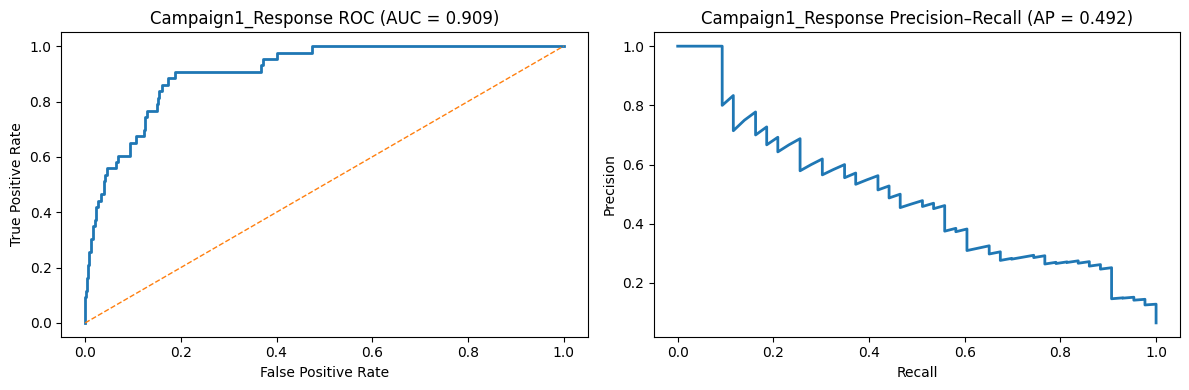


Top positive coefficients (increase odds of acceptance):
Household_Income            2.3316
Spend_Wines                 1.3006
Web_Visits_Month            0.8330
Purchases_Catalog           0.6615
Spend_Meat                  0.4745
Kids_Count                  0.2918
Edu_2ndCycle                0.1390
Spend_Gold                  0.1270
Days_Since_Last_Purchase    0.0914
Customer_Age                0.0863
dtype: float64

Top negative coefficients (decrease odds of acceptance):
Marital_Divorced             -0.3537
Purchases_Store              -0.3905
Edu_Graduation               -0.3978
Days_Since_Became_Customer   -0.4158
Marital_Together             -0.4907
Spend_Fruits                 -0.6275
Had_Complaint                -0.7147
Teens_Count                  -0.7720
Edu_PhD                      -0.8219
Edu_Master                   -1.1363
dtype: float64

=== Logistic Regression (scaled, class_weight='balanced') — Campaign2_Response ===

Classification report:
              precision   

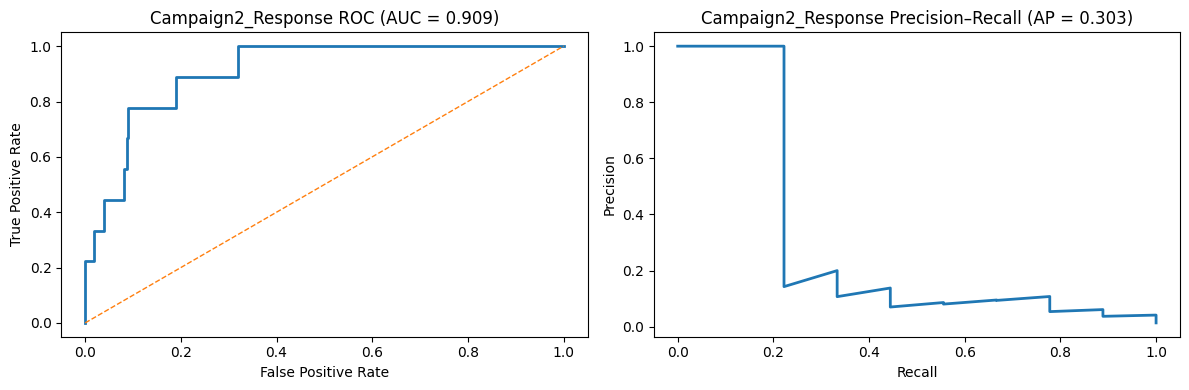


Top positive coefficients (increase odds of acceptance):
Web_Visits_Month            2.4287
Household_Income            1.9384
Spend_Wines                 1.6315
Marital_Together            1.6085
Purchases_Catalog           1.3162
Edu_2ndCycle                0.9053
Spend_Gold                  0.8155
Marital_Divorced            0.7650
Purchases_Store             0.6366
Days_Since_Last_Purchase    0.3422
dtype: float64

Top negative coefficients (decrease odds of acceptance):
Kids_Count        -0.7185
Had_Complaint     -0.7451
Spend_Fish        -0.8924
Purchases_Deals   -0.9392
Spend_Meat        -0.9711
Edu_PhD           -1.1135
Purchases_Web     -1.1710
Teens_Count       -1.2861
Marital_Married   -1.8515
Edu_Master        -1.9653
dtype: float64

=== Logistic Regression (scaled, class_weight='balanced') — Campaign3_Response ===

Classification report:
              precision    recall  f1-score   support

           0      0.971     0.761     0.853       611
           1      0.193    

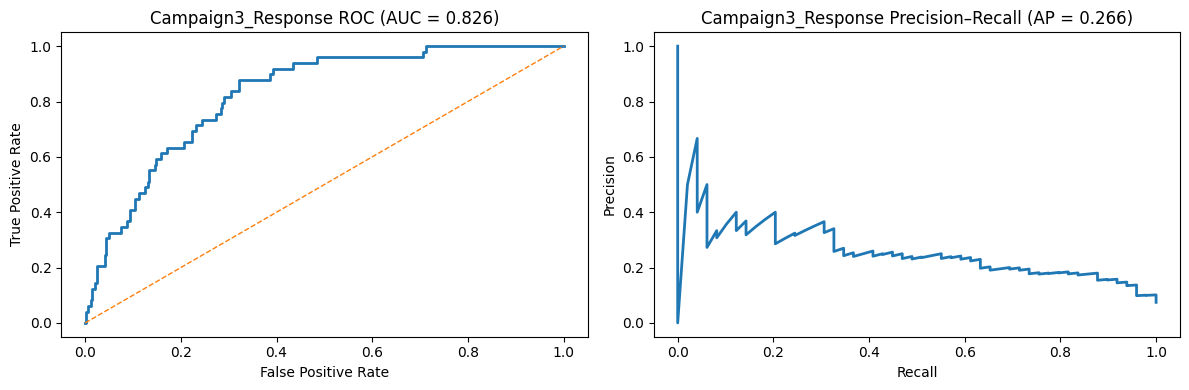


Top positive coefficients (increase odds of acceptance):
Purchases_Catalog    1.7387
Spend_Gold           0.9897
Web_Visits_Month     0.6096
Marital_Married      0.5252
Marital_Together     0.4108
Marital_Single       0.3769
Kids_Count           0.3582
Edu_PhD              0.2284
Marital_Divorced     0.1555
Purchases_Web        0.0960
dtype: float64

Top negative coefficients (decrease odds of acceptance):
Edu_Master                   -0.2141
Customer_Age                 -0.2351
Spend_Meat                   -0.2798
Days_Since_Became_Customer   -0.2799
Household_Income             -0.3896
Purchases_Deals              -0.5331
Edu_Graduation               -0.5380
Had_Complaint                -0.5674
Spend_Fish                   -0.6025
Purchases_Store              -0.7058
dtype: float64

=== Logistic Regression (scaled, class_weight='balanced') — Campaign4_Response ===

Classification report:
              precision    recall  f1-score   support

           0      0.980     0.812     0.8

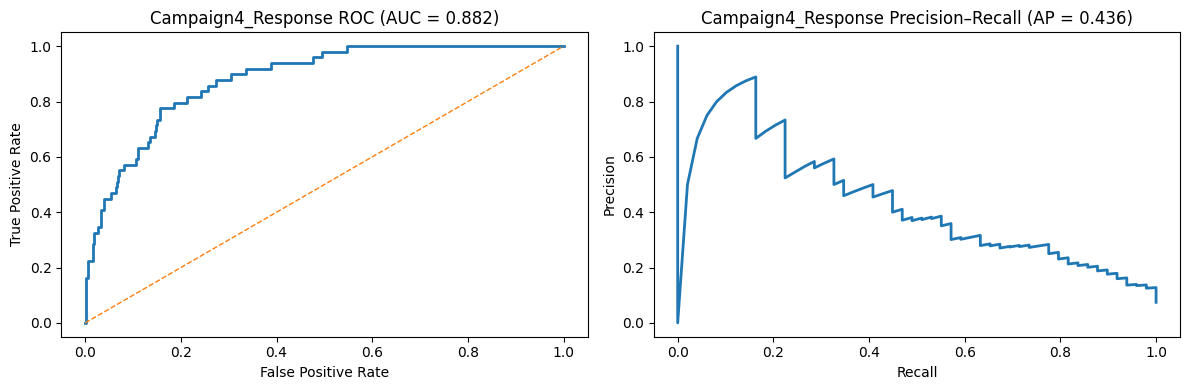


Top positive coefficients (increase odds of acceptance):
Spend_Wines                 2.3003
Household_Income            1.9672
Web_Visits_Month            0.9343
Edu_2ndCycle                0.3902
Purchases_Deals             0.1825
Days_Since_Last_Purchase    0.1698
Purchases_Catalog           0.0371
Purchases_Store            -0.0119
Edu_Graduation             -0.0279
Marital_Single             -0.0685
dtype: float64

Top negative coefficients (decrease odds of acceptance):
Marital_Married    -0.3209
Spend_Gold         -0.3481
Spend_Fish         -0.3658
Teens_Count        -0.3913
Marital_Divorced   -0.4211
Spend_Sweets       -0.5086
Kids_Count         -0.7325
Had_Complaint      -0.8171
Spend_Meat         -1.0861
Edu_PhD            -1.2866
dtype: float64

=== Logistic Regression (scaled, class_weight='balanced') — Campaign5_Response ===

Classification report:
              precision    recall  f1-score   support

           0      0.993     0.897     0.942       612
           1     

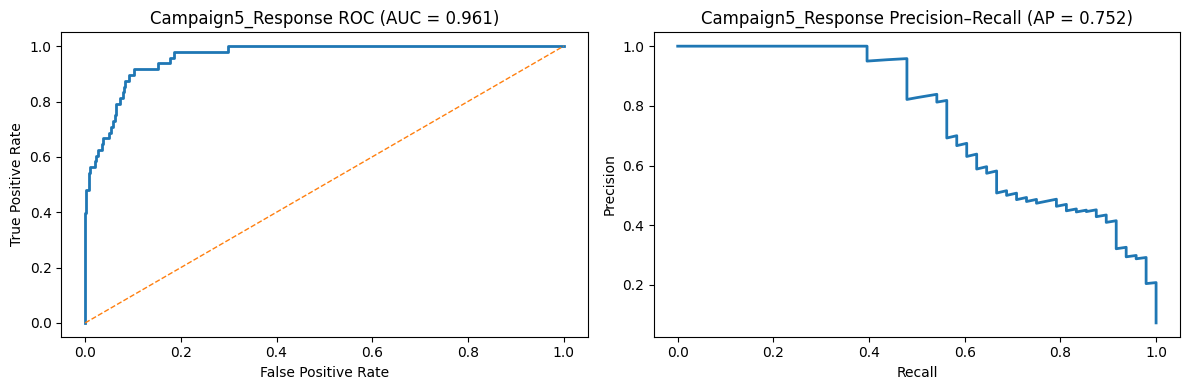


Top positive coefficients (increase odds of acceptance):
Household_Income              3.2316
Spend_Wines                   2.2816
Had_Complaint                 0.2345
Spend_Gold                    0.2159
Purchases_Web                 0.1260
Spend_Sweets                  0.0387
Days_Since_Became_Customer    0.0191
Purchases_Catalog             0.0004
Days_Since_Last_Purchase     -0.0863
Web_Visits_Month             -0.1304
dtype: float64

Top negative coefficients (decrease odds of acceptance):
Purchases_Deals    -0.5441
Edu_Graduation     -0.5663
Spend_Fish         -0.6555
Teens_Count        -0.8541
Edu_Master         -1.0568
Edu_PhD            -1.1293
Marital_Married    -1.1970
Marital_Together   -1.3320
Marital_Divorced   -1.5637
Marital_Single     -2.3410
dtype: float64


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve
)

# ----------------------------
# 1) Features (X) and targets (y)
# ----------------------------
X = df_vif_scaled.copy()  # SCALED features (continuous scaled, binaries passthrough)

campaign_cols = [
    "Campaign1_Response",
    "Campaign2_Response",
    "Campaign3_Response",
    "Campaign4_Response",
    "Campaign5_Response",
]

# Safety check
assert len(X) == len(df), "X and df have different lengths. Align indexes before running."

# ----------------------------
# 2) Helper to plot curves
# ----------------------------
def plot_curves(y_test, y_proba, title_prefix=""):
    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    # PR
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ROC curve
    axes[0].plot(fpr, tpr, lw=2)
    axes[0].plot([0, 1], [0, 1], ls="--", lw=1)
    axes[0].set_title(f"{title_prefix} ROC (AUC = {roc_auc:.3f})")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")

    # PR curve
    axes[1].plot(recall, precision, lw=2)
    axes[1].set_title(f"{title_prefix} Precision–Recall (AP = {pr_auc:.3f})")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")

    plt.tight_layout()
    plt.show()

# ----------------------------
# 3) Run logistic regression per campaign
# ----------------------------
for target in campaign_cols:
    print("\n" + "="*80)
    print(f"=== Logistic Regression (scaled, class_weight='balanced') — {target} ===")

    y = df[target].astype(int)

    # Train/test split (stratify to preserve class ratio)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.30,
        random_state=42,
        stratify=y
    )

    # Model
    logreg = LogisticRegression(
        class_weight="balanced",
        solver="liblinear",   # good choice for small/medium dataset
        max_iter=2000
    )

    # Fit
    logreg.fit(X_train, y_train)

    # Predictions
    y_pred = logreg.predict(X_test)
    y_proba = logreg.predict_proba(X_test)[:, 1]

    # Metrics
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=3))

    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
    print("\nConfusion matrix:")
    print(cm_df)

    # AUCs + curves
    try:
        plot_curves(y_test, y_proba, title_prefix=target)
    except Exception as e:
        print(f"(Plotting skipped due to error: {e})")

    # Coefficients
    coef = pd.Series(logreg.coef_[0], index=X.columns).sort_values(ascending=False)
    top_pos = coef.head(10)
    top_neg = coef.tail(10)

    print("\nTop positive coefficients (increase odds of acceptance):")
    print(top_pos.round(4))

    print("\nTop negative coefficients (decrease odds of acceptance):")
    print(top_neg.round(4))

### ROC-AUC and PR-AUC Evaluation  

To better evaluate the logistic regression model for **Campaign 1**, two complementary metrics and their curves were generated:  

- **ROC Curve & AUC (Area Under the Curve):**  
  Measures the model’s ability to rank responders above non-responders across all thresholds.  
  - **ROC-AUC close to 1.0** indicates strong ranking power (responders consistently receive higher predicted probabilities).  

- **Precision-Recall Curve & AUC:**  
  Especially useful in imbalanced datasets where responders are rare.  
  - **PR-AUC is compared against the baseline responder rate** (≈ 6.5% in this case).  
  - A significantly higher PR-AUC shows the model can identify responders more precisely than random chance.  

These plots allow us to go beyond accuracy and classification reports, confirming that the model is not only separating classes effectively but also remains practical for marketing use cases where positive responses are scarce.  

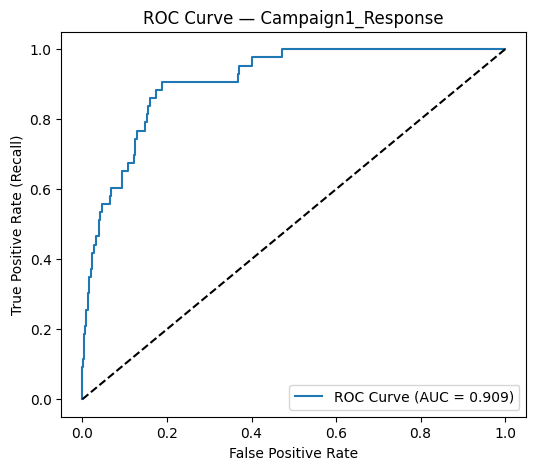

ROC-AUC: 0.909


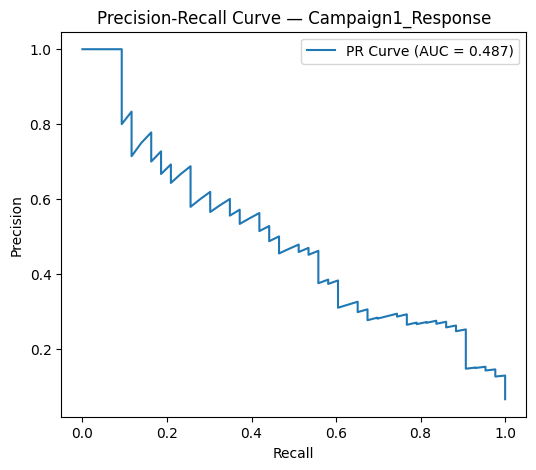

PR-AUC: 0.487


In [22]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# --- Campaign 1 Example ---
target = "Campaign1_Response"

# Split again
X = df_vif_scaled.copy()
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Fit logistic regression with balanced weights
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
log_reg.fit(X_train, y_train)

# Predict probabilities for the positive class (responders)
y_proba = log_reg.predict_proba(X_test)[:, 1]

# === ROC-AUC ===
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title(f"ROC Curve — {target}")
plt.legend(loc="lower right")
plt.show()

print(f"ROC-AUC: {roc_auc:.3f}")

# === Precision-Recall Curve ===
prec, rec, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(rec, prec)

plt.figure(figsize=(6, 5))
plt.plot(rec, prec, label=f"PR Curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve — {target}")
plt.legend(loc="upper right")
plt.show()

print(f"PR-AUC: {pr_auc:.3f}")

### XGBoost Models for Campaign Response Prediction

To compare against logistic regression, I trained **XGBoost** classifiers for each campaign response (`Campaign1_Response` … `Campaign5_Response`) using the already prepared feature set (`df_vif_scaled`).

**What this does:**
1. **Features & Targets**
   - `X` = scaled/passthrough features from `df_vif_scaled`.
   - `y` = one campaign’s 0/1 response column.

2. **Train/Test Split**
   - 70% train / 30% test with `stratify=y` to keep the original class ratio (responses are rare).

3. **Imbalance Handling**
   - `scale_pos_weight = (negatives/positives)` makes the model pay more attention to the minority “Yes” class without resampling.

4. **Model Setup (per campaign)**
   - `objective="binary:logistic"` for probabilities.
   - Reasonable defaults for a first pass:
     - `n_estimators=300`, `max_depth=4`, `learning_rate=0.05`,
     - `subsample=0.8`, `colsample_bytree=0.8`,
     - `eval_metric="logloss"`, `random_state=42`.

5. **Evaluation**
   - **Classification report** (precision/recall/F1).
   - **Confusion matrix** to see types of errors.
   - **ROC curve + AUC** to judge ranking (threshold-free).
   - **Precision–Recall curve + Average Precision (PR-AUC)**, which is more informative under strong class imbalance.

6. **Feature Importance**
   - Prints the **top 15 features** by XGBoost’s gain/importance metric so we can see which attributes the trees use most.

**How to read results**
- **ROC-AUC** near 1.0 → excellent separation; **PR-AUC** much larger than the positive rate → useful targeting on imbalanced data.
- Compare the **top features** across campaigns to build campaign-specific customer profiles (e.g., income/spend/engagement drivers).
- If needed, tune hyperparameters or adjust `scale_pos_weight` and thresholds to improve precision vs. recall tradeoffs for your marketing goals.


=== XGBoost — Campaign1_Response ===


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:17:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification report:
              precision    recall  f1-score   support

           0      0.969     0.948     0.958       617
           1      0.429     0.558     0.485        43

    accuracy                          0.923       660
   macro avg      0.699     0.753     0.722       660
weighted avg      0.933     0.923     0.927       660


Confusion matrix:
          Pred 0  Pred 1
Actual 0     585      32
Actual 1      19      24


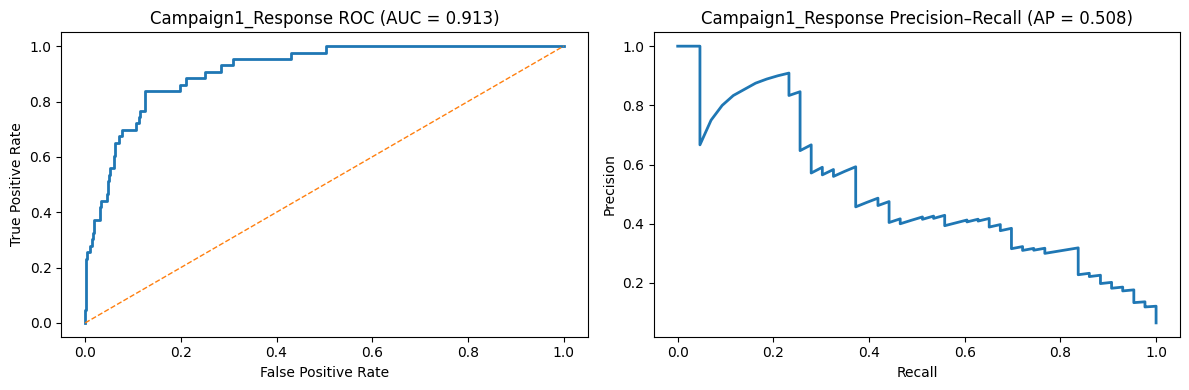


Top 15 features by importance:
Household_Income              0.2060
Spend_Meat                    0.0689
Teens_Count                   0.0676
Spend_Wines                   0.0540
Kids_Count                    0.0495
Purchases_Deals               0.0491
Spend_Fruits                  0.0385
Web_Visits_Month              0.0377
Purchases_Catalog             0.0361
Purchases_Web                 0.0319
Edu_PhD                       0.0306
Days_Since_Became_Customer    0.0305
Edu_2ndCycle                  0.0299
Customer_Age                  0.0290
Spend_Sweets                  0.0289
dtype: float32

=== XGBoost — Campaign2_Response ===


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:17:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification report:
              precision    recall  f1-score   support

           0      0.988     0.998     0.993       651
           1      0.500     0.111     0.182         9

    accuracy                          0.986       660
   macro avg      0.744     0.555     0.587       660
weighted avg      0.981     0.986     0.982       660


Confusion matrix:
          Pred 0  Pred 1
Actual 0     650       1
Actual 1       8       1


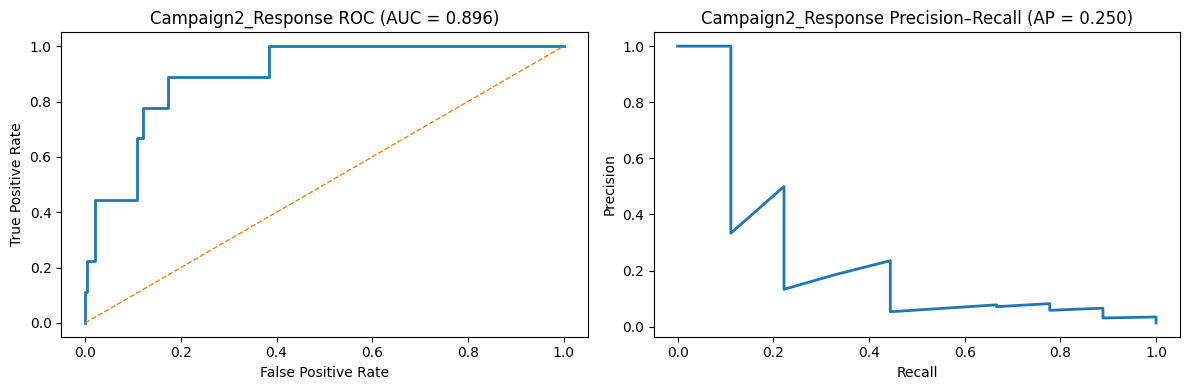


Top 15 features by importance:
Spend_Wines                   0.1409
Purchases_Catalog             0.0745
Kids_Count                    0.0657
Purchases_Deals               0.0625
Marital_Married               0.0614
Edu_PhD                       0.0552
Spend_Gold                    0.0548
Household_Income              0.0508
Spend_Fruits                  0.0409
Marital_Single                0.0394
Web_Visits_Month              0.0392
Edu_Master                    0.0385
Spend_Meat                    0.0366
Spend_Sweets                  0.0338
Days_Since_Became_Customer    0.0318
dtype: float32

=== XGBoost — Campaign3_Response ===


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:17:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification report:
              precision    recall  f1-score   support

           0      0.941     0.974     0.957       611
           1      0.429     0.245     0.312        49

    accuracy                          0.920       660
   macro avg      0.685     0.609     0.635       660
weighted avg      0.903     0.920     0.909       660


Confusion matrix:
          Pred 0  Pred 1
Actual 0     595      16
Actual 1      37      12


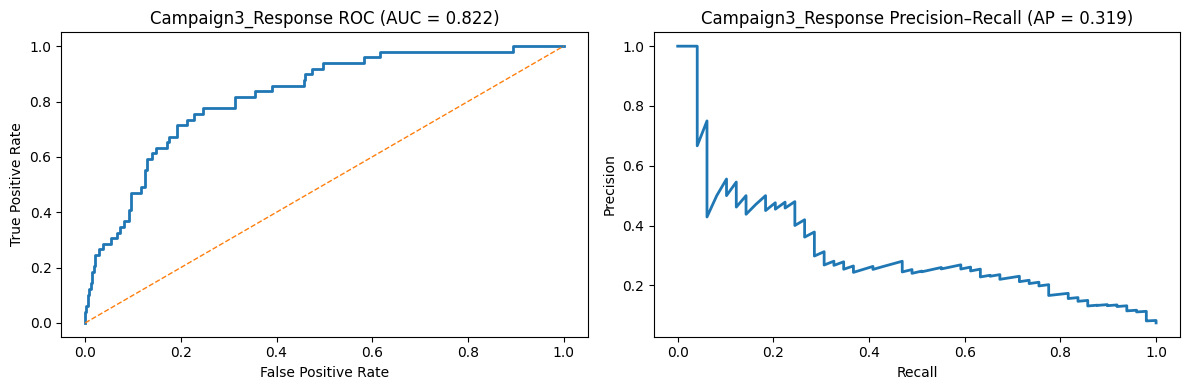


Top 15 features by importance:
Purchases_Store               0.0877
Spend_Gold                    0.0736
Purchases_Catalog             0.0683
Purchases_Web                 0.0540
Household_Income              0.0477
Kids_Count                    0.0477
Spend_Meat                    0.0443
Spend_Wines                   0.0442
Spend_Fish                    0.0431
Purchases_Deals               0.0405
Customer_Age                  0.0397
Web_Visits_Month              0.0393
Edu_PhD                       0.0376
Spend_Sweets                  0.0363
Days_Since_Became_Customer    0.0355
dtype: float32

=== XGBoost — Campaign4_Response ===


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:17:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification report:
              precision    recall  f1-score   support

           0      0.957     0.951     0.954       611
           1      0.434     0.469     0.451        49

    accuracy                          0.915       660
   macro avg      0.696     0.710     0.703       660
weighted avg      0.918     0.915     0.917       660


Confusion matrix:
          Pred 0  Pred 1
Actual 0     581      30
Actual 1      26      23


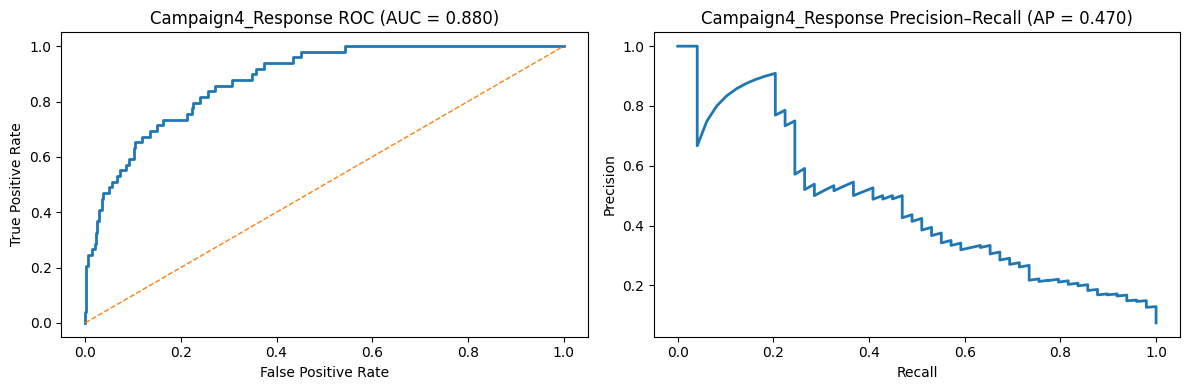


Top 15 features by importance:
Spend_Wines          0.1455
Spend_Meat           0.0553
Web_Visits_Month     0.0525
Kids_Count           0.0516
Household_Income     0.0479
Edu_2ndCycle         0.0436
Purchases_Store      0.0418
Spend_Sweets         0.0409
Spend_Fruits         0.0382
Spend_Fish           0.0381
Edu_PhD              0.0365
Customer_Age         0.0360
Spend_Gold           0.0329
Marital_Single       0.0319
Purchases_Catalog    0.0313
dtype: float32

=== XGBoost — Campaign5_Response ===


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:17:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification report:
              precision    recall  f1-score   support

           0      0.980     0.962     0.971       612
           1      0.610     0.750     0.673        48

    accuracy                          0.947       660
   macro avg      0.795     0.856     0.822       660
weighted avg      0.953     0.947     0.949       660


Confusion matrix:
          Pred 0  Pred 1
Actual 0     589      23
Actual 1      12      36


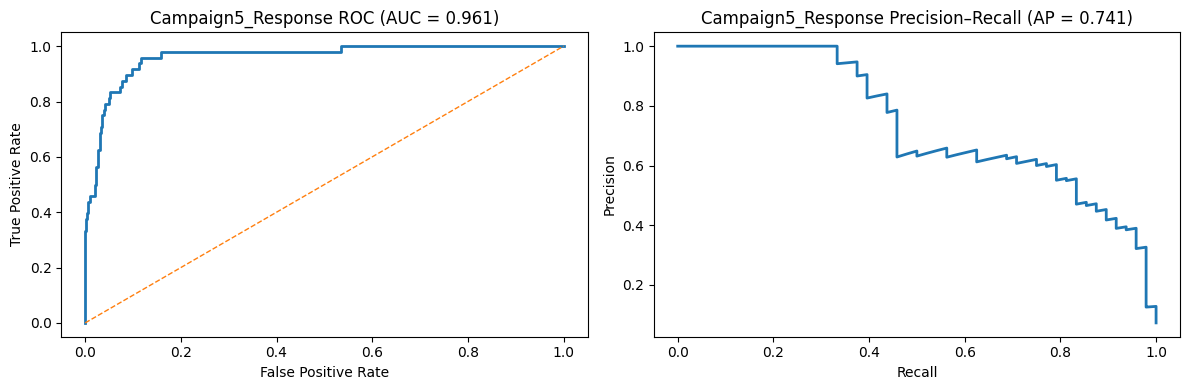


Top 15 features by importance:
Household_Income              0.2840
Purchases_Deals               0.0801
Spend_Wines                   0.0731
Teens_Count                   0.0667
Purchases_Catalog             0.0663
Edu_2ndCycle                  0.0382
Web_Visits_Month              0.0311
Spend_Meat                    0.0289
Spend_Gold                    0.0274
Spend_Fish                    0.0273
Days_Since_Became_Customer    0.0257
Marital_Married               0.0253
Customer_Age                  0.0249
Marital_Single                0.0234
Edu_PhD                       0.0222
dtype: float32


In [23]:
import xgboost as xgb
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import pandas as pd

# Features (scaled)
X = df_vif_scaled.copy()
campaign_cols = [
    "Campaign1_Response",
    "Campaign2_Response",
    "Campaign3_Response",
    "Campaign4_Response",
    "Campaign5_Response",
]

# Helper to plot ROC and PR curves
def plot_curves(y_test, y_proba, title_prefix=""):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ROC
    axes[0].plot(fpr, tpr, lw=2)
    axes[0].plot([0, 1], [0, 1], ls="--", lw=1)
    axes[0].set_title(f"{title_prefix} ROC (AUC = {roc_auc:.3f})")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")

    # PR
    axes[1].plot(recall, precision, lw=2)
    axes[1].set_title(f"{title_prefix} Precision–Recall (AP = {pr_auc:.3f})")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")

    plt.tight_layout()
    plt.show()


# Loop over campaigns
for target in campaign_cols:
    print("\n" + "="*80)
    print(f"=== XGBoost — {target} ===")

    y = df[target].astype(int)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # XGBoost model
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42,
        scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),  # handle imbalance
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
    )

    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=3))

    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion matrix:")
    print(pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"]))

    # Curves
    plot_curves(y_test, y_proba, title_prefix=target)

    # Feature importance
    importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("\nTop 15 features by importance:")
    print(importance.head(15).round(4))

### 🧪 XGBoost Model Optimization for Campaign 1

In this section, we train an XGBoost model to predict responses to **Campaign 1**.

We use `RandomizedSearchCV` to optimize key hyperparameters and improve model performance.  
The model is evaluated using a classification report and ROC-AUC score.

In [24]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Features (scaled)
X = df_vif_scaled.copy()
y = df["Campaign1_Response"].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Base model
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),  # imbalance
)

# Parameter grid (expanded but reasonable)
param_dist = {
    "n_estimators": [200, 300, 500],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.5],  # min loss reduction
    "min_child_weight": [1, 3, 5, 7],  # regularization
}

# Random search
random_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=20,               # ~20 configs to balance runtime and exploration
    scoring="average_precision",  # PR-AUC works best for imbalance
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit
random_search.fit(X_train, y_train)

# Best params
print("Best params:", random_search.best_params_)

# Evaluate
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

print("ROC-AUC:", roc_auc_score(y_test, y_proba))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:02] WARN

[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=7, min_child_weight=5, n_estimators=500, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=7, min_child_weight=5, n_estimators=500, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, subsa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:02] WARN

[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, subsample=0.8; to

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:02] WARN

[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=7, n_estimators=500, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=7, n_estimators=500, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=500, subsamp

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:03] WARN

[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=300, subsampl

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:18:03] WARN

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.1s
Best params: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}

Classification report:
              precision    recall  f1-score   support

           0      0.963     0.958     0.960       617
           1      0.435     0.465     0.449        43

    accuracy                          0.926       660
   macro avg      0.699     0.711     0.705       660
weighted avg      0.928     0.926     0.927       660

ROC-AUC: 0.9168142927141834


## XGBoost w/ optimized parameters


=== XGBoost — Campaign1_Response ===

Classification report:
              precision    recall  f1-score   support

           0      0.963     0.958     0.960       617
           1      0.435     0.465     0.449        43

    accuracy                          0.926       660
   macro avg      0.699     0.711     0.705       660
weighted avg      0.928     0.926     0.927       660


Confusion matrix:
          Pred 0  Pred 1
Actual 0     591      26
Actual 1      23      20


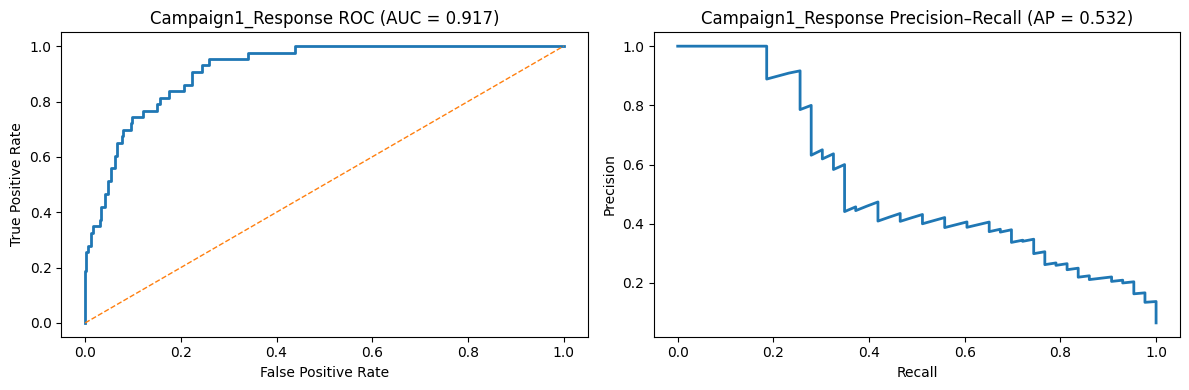


Top 15 features by importance:
Household_Income              0.2159
Teens_Count                   0.0667
Purchases_Deals               0.0658
Kids_Count                    0.0622
Spend_Meat                    0.0618
Spend_Wines                   0.0517
Edu_Master                    0.0494
Marital_Single                0.0357
Purchases_Catalog             0.0355
Purchases_Web                 0.0328
Web_Visits_Month              0.0319
Spend_Fruits                  0.0317
Days_Since_Became_Customer    0.0288
Days_Since_Last_Purchase      0.0261
Marital_Together              0.0256
dtype: float32

=== XGBoost — Campaign2_Response ===

Classification report:
              precision    recall  f1-score   support

           0      0.988     1.000     0.994       651
           1      1.000     0.111     0.200         9

    accuracy                          0.988       660
   macro avg      0.994     0.556     0.597       660
weighted avg      0.988     0.988     0.983       660


Confusio

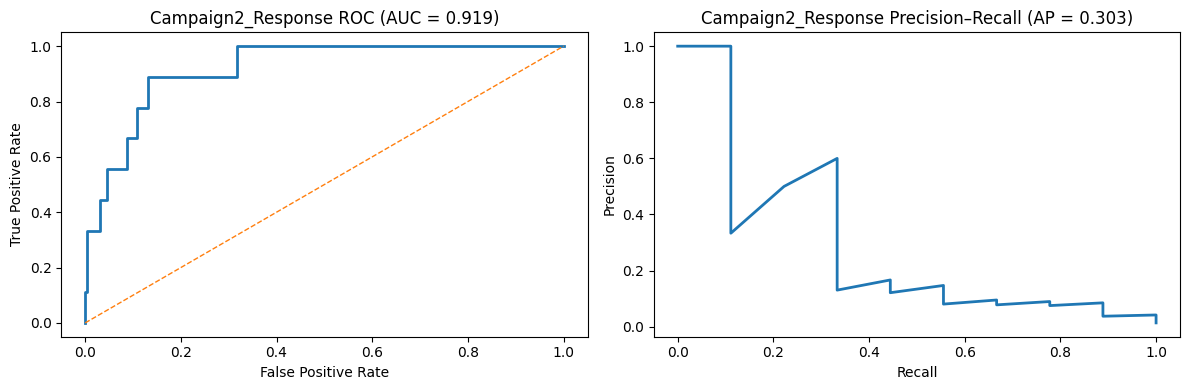


Top 15 features by importance:
Spend_Wines          0.1583
Purchases_Catalog    0.0836
Purchases_Deals      0.0732
Kids_Count           0.0637
Edu_Master           0.0541
Spend_Meat           0.0535
Spend_Gold           0.0534
Household_Income     0.0516
Spend_Fruits         0.0477
Marital_Married      0.0420
Web_Visits_Month     0.0403
Spend_Fish           0.0375
Purchases_Store      0.0350
Customer_Age         0.0275
Spend_Sweets         0.0267
dtype: float32

=== XGBoost — Campaign3_Response ===

Classification report:
              precision    recall  f1-score   support

           0      0.936     0.984     0.959       611
           1      0.444     0.163     0.239        49

    accuracy                          0.923       660
   macro avg      0.690     0.573     0.599       660
weighted avg      0.900     0.923     0.906       660


Confusion matrix:
          Pred 0  Pred 1
Actual 0     601      10
Actual 1      41       8


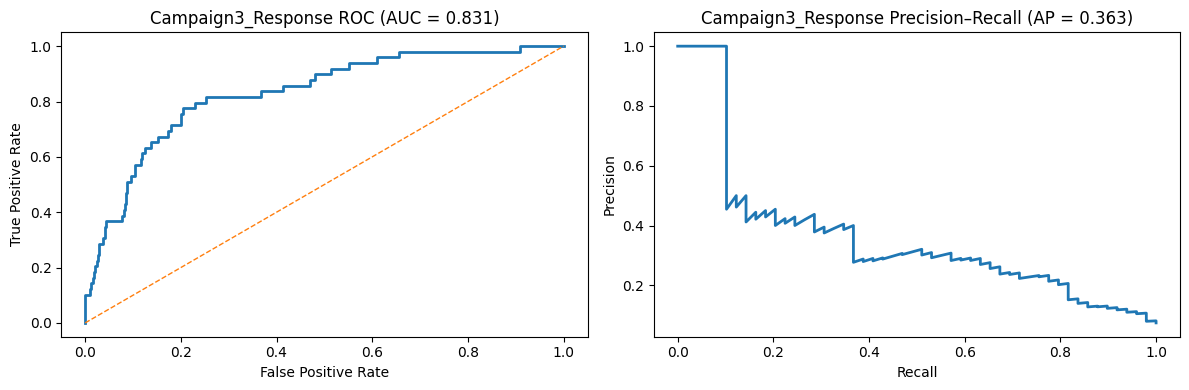


Top 15 features by importance:
Purchases_Store      0.0821
Purchases_Catalog    0.0800
Spend_Gold           0.0753
Purchases_Web        0.0639
Spend_Fish           0.0507
Kids_Count           0.0456
Web_Visits_Month     0.0449
Spend_Meat           0.0441
Edu_2ndCycle         0.0429
Spend_Wines          0.0426
Household_Income     0.0401
Purchases_Deals      0.0400
Spend_Fruits         0.0392
Spend_Sweets         0.0389
Customer_Age         0.0349
dtype: float32

=== XGBoost — Campaign4_Response ===

Classification report:
              precision    recall  f1-score   support

           0      0.950     0.974     0.962       611
           1      0.529     0.367     0.434        49

    accuracy                          0.929       660
   macro avg      0.740     0.671     0.698       660
weighted avg      0.919     0.929     0.923       660


Confusion matrix:
          Pred 0  Pred 1
Actual 0     595      16
Actual 1      31      18


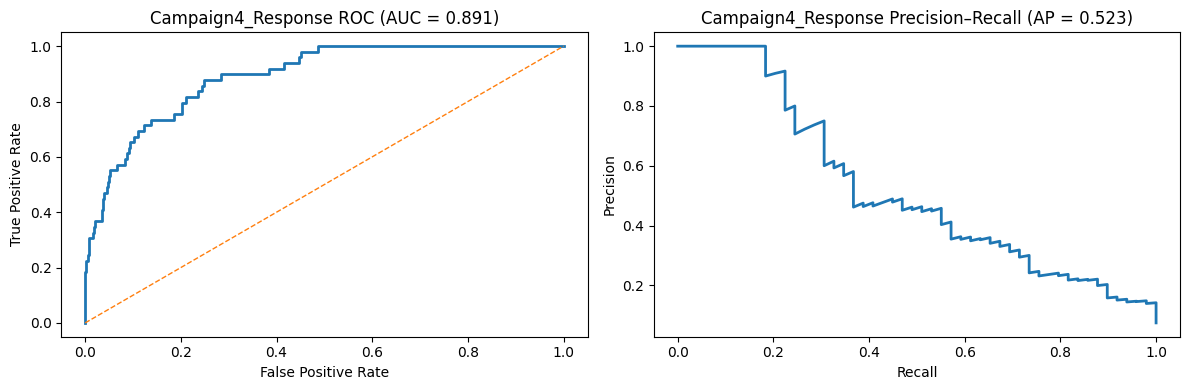


Top 15 features by importance:
Spend_Wines                   0.1648
Edu_2ndCycle                  0.0924
Web_Visits_Month              0.0531
Spend_Meat                    0.0493
Marital_Divorced              0.0435
Purchases_Store               0.0422
Household_Income              0.0408
Marital_Together              0.0374
Edu_PhD                       0.0368
Purchases_Catalog             0.0360
Spend_Gold                    0.0349
Marital_Single                0.0346
Spend_Fruits                  0.0333
Days_Since_Became_Customer    0.0304
Customer_Age                  0.0303
dtype: float32

=== XGBoost — Campaign5_Response ===

Classification report:
              precision    recall  f1-score   support

           0      0.974     0.969     0.971       612
           1      0.627     0.667     0.646        48

    accuracy                          0.947       660
   macro avg      0.801     0.818     0.809       660
weighted avg      0.949     0.947     0.948       660


Confusio

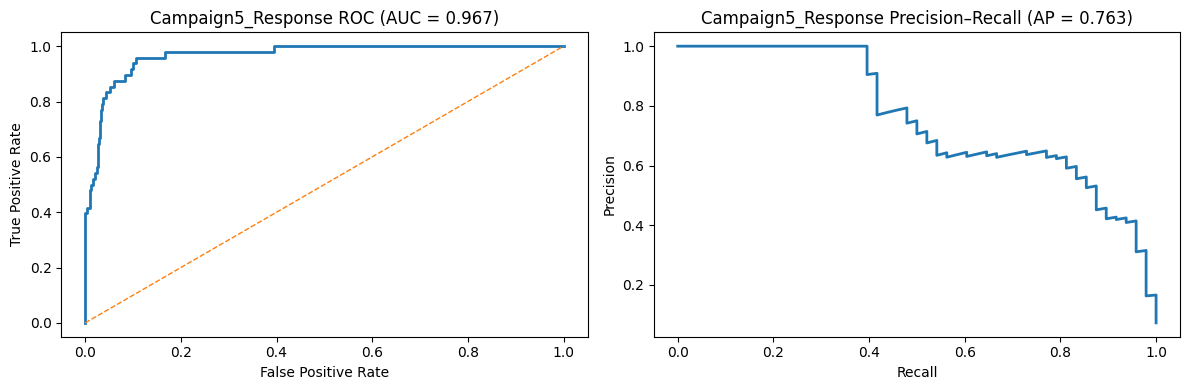


Top 15 features by importance:
Household_Income     0.2825
Marital_Together     0.0833
Spend_Wines          0.0743
Purchases_Catalog    0.0617
Purchases_Deals      0.0600
Edu_2ndCycle         0.0562
Teens_Count          0.0454
Web_Visits_Month     0.0350
Spend_Meat           0.0301
Customer_Age         0.0240
Spend_Gold           0.0233
Spend_Fish           0.0231
Purchases_Web        0.0217
Edu_Graduation       0.0202
Spend_Fruits         0.0199
dtype: float32


In [25]:
import xgboost as xgb
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Features (scaled)
X = df_vif_scaled.copy()
campaign_cols = [
    "Campaign1_Response",
    "Campaign2_Response",
    "Campaign3_Response",
    "Campaign4_Response",
    "Campaign5_Response",
]

# Helper to plot ROC and PR curves
def plot_curves(y_test, y_proba, title_prefix=""):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ROC
    axes[0].plot(fpr, tpr, lw=2)
    axes[0].plot([0, 1], [0, 1], ls="--", lw=1)
    axes[0].set_title(f"{title_prefix} ROC (AUC = {roc_auc:.3f})")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")

    # PR
    axes[1].plot(recall, precision, lw=2)
    axes[1].set_title(f"{title_prefix} Precision–Recall (AP = {pr_auc:.3f})")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")

    plt.tight_layout()
    plt.show()


# Loop over campaigns
for target in campaign_cols:
    print("\n" + "="*80)
    print(f"=== XGBoost — {target} ===")

    y = df[target].astype(int)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Optimized XGBoost model
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),  # imbalance handling
        n_estimators=200,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        gamma=0,
    )

    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=3))

    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion matrix:")
    print(pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"]))

    # Curves
    plot_curves(y_test, y_proba, title_prefix=target)

    # Feature importance
    importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("\nTop 15 features by importance:")
    print(importance.head(15).round(4))

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Client_ID                   2200 non-null   int64  
 1   Household_Income            2200 non-null   float64
 2   Kids_Count                  2200 non-null   int64  
 3   Teens_Count                 2200 non-null   int64  
 4   Days_Since_Last_Purchase    2200 non-null   int64  
 5   Spend_Wines                 2200 non-null   int64  
 6   Spend_Fruits                2200 non-null   int64  
 7   Spend_Meat                  2200 non-null   int64  
 8   Spend_Fish                  2200 non-null   int64  
 9   Spend_Sweets                2200 non-null   int64  
 10  Spend_Gold                  2200 non-null   int64  
 11  Purchases_Deals             2200 non-null   int64  
 12  Purchases_Web               2200 non-null   int64  
 13  Purchases_Catalog           2200 

### Export DataFrame

In [30]:
# Rename DataFrame
df_final = df.copy()

# Save with new name to CSV
df_final.to_csv("df_final.csv", index=False)

In [28]:
print("RF Features:", X.columns.tolist())
print("LR Features:", df_vif_scaled.columns.tolist())

RF Features: ['Household_Income', 'Kids_Count', 'Teens_Count', 'Days_Since_Last_Purchase', 'Spend_Wines', 'Spend_Fruits', 'Spend_Meat', 'Spend_Fish', 'Spend_Sweets', 'Spend_Gold', 'Purchases_Deals', 'Purchases_Web', 'Purchases_Catalog', 'Purchases_Store', 'Web_Visits_Month', 'Customer_Age', 'Days_Since_Became_Customer', 'Had_Complaint', 'Marital_Divorced', 'Marital_Married', 'Marital_Single', 'Marital_Together', 'Edu_2ndCycle', 'Edu_Graduation', 'Edu_Master', 'Edu_PhD']
LR Features: ['Household_Income', 'Kids_Count', 'Teens_Count', 'Days_Since_Last_Purchase', 'Spend_Wines', 'Spend_Fruits', 'Spend_Meat', 'Spend_Fish', 'Spend_Sweets', 'Spend_Gold', 'Purchases_Deals', 'Purchases_Web', 'Purchases_Catalog', 'Purchases_Store', 'Web_Visits_Month', 'Customer_Age', 'Days_Since_Became_Customer', 'Had_Complaint', 'Marital_Divorced', 'Marital_Married', 'Marital_Single', 'Marital_Together', 'Edu_2ndCycle', 'Edu_Graduation', 'Edu_Master', 'Edu_PhD']


### 🌲 Random Forest Modeling for Campaign Responses

We apply Random Forest classifiers to predict customer responses for each campaign  
using the **VIF-filtered and scaled feature set** (`df_vif_scaled`).  
This helps us evaluate model performance and extract the **top predictive features** per campaign.

In [29]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

campaign_cols = [
    "Campaign1_Response", "Campaign2_Response", "Campaign3_Response",
    "Campaign4_Response", "Campaign5_Response"
]

# Same feature set as Logistic Regression (already VIF-filtered, scaled, etc.)
# So no need to drop engineered/leakage features here — df_vif_scaled is clean.
X_full = df_vif_scaled.copy()

for target in campaign_cols:
    print(f"\n=== Feature Importance for {target} ===")

    y = df[target].astype(int)  # target from original df, aligned by index

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y,
        test_size=0.30, random_state=42, stratify=y
    )

    # Impute missing (precaution — though df_vif_scaled likely has none)
    imp = SimpleImputer(strategy="median")
    X_train_imp = imp.fit_transform(X_train)
    X_test_imp  = imp.transform(X_test)

    # Random Forest
    rf = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )
    rf.fit(X_train_imp, y_train)

    # Evaluation
    y_pred = rf.predict(X_test_imp)
    print(classification_report(y_test, y_pred, digits=3))

    # Feature importances
    importances = pd.Series(
        rf.feature_importances_, index=X_full.columns
    ).sort_values(ascending=False)

    top15 = importances.head(15)
    print("\nTop 15 features:")
    print(top15.to_frame("importance"))


=== Feature Importance for Campaign1_Response ===
              precision    recall  f1-score   support

           0      0.949     0.995     0.972       617
           1      0.769     0.233     0.357        43

    accuracy                          0.945       660
   macro avg      0.859     0.614     0.664       660
weighted avg      0.937     0.945     0.931       660


Top 15 features:
                            importance
Household_Income              0.201094
Spend_Meat                    0.126795
Purchases_Catalog             0.097573
Spend_Wines                   0.096418
Spend_Fish                    0.065215
Spend_Sweets                  0.053669
Spend_Fruits                  0.051084
Days_Since_Became_Customer    0.038992
Purchases_Web                 0.038810
Spend_Gold                    0.034569
Purchases_Store               0.032107
Days_Since_Last_Purchase      0.030327
Customer_Age                  0.028875
Purchases_Deals               0.026439
Web_Visits_Month   

### 🔍 Random Forest Hyperparameter Optimization

In this step, we apply **RandomizedSearchCV** to optimize the Random Forest model for one of the campaigns.

- We use a reasonable parameter grid to explore depth, splits, and feature sampling.
- The model is evaluated using **average precision (PR-AUC)**, which is more appropriate for imbalanced classification tasks.
- After tuning, we evaluate the best-performing model on the test set using standard classification metrics.

In [30]:
from sklearn.model_selection import RandomizedSearchCV

# Base RF
rf_base = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

# Parameter grid
param_dist = {
    "max_depth": [5, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
    "n_estimators": [200, 500, 800]
}

# Randomized search (limit iterations to keep runtime reasonable)
rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=25,   # try 25 combos
    cv=3,
    scoring="average_precision",  # PR-AUC for imbalanced data
    random_state=42,
    n_jobs=-1,
    verbose=2
)

rf_search.fit(X_train_imp, y_train)

print("Best params:", rf_search.best_params_)

best_rf = rf_search.best_estimator_
y_pred = best_rf.predict(X_test_imp)
print(classification_report(y_test, y_pred, digits=3))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END max_depth=5, max_features=0.3, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   1.3s
[CV] END max_depth=None, max_features=0.7, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   1.8s
[CV] END max_depth=None, max_features=0.7, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   1.8s
[CV] END max_depth=None, max_features=0.7, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   1.8s
[CV] END max_depth=5, max_features=0.3, min_samples_leaf=1, min_samples_split=5, n_estimators=800; to

### Random Forest w/ df_vif_scaled w/ optimized hyperparameters.

In [31]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

campaign_cols = [
    "Campaign1_Response", "Campaign2_Response", "Campaign3_Response",
    "Campaign4_Response", "Campaign5_Response"
]

# Same feature set as Logistic Regression (already VIF-filtered, scaled, etc.)
# So no need to drop engineered/leakage features here — df_vif_scaled is clean.
X_full = df_vif_scaled.copy()

for target in campaign_cols:
    print(f"\n=== Feature Importance for {target} ===")

    y = df[target].astype(int)  # target from original df, aligned by index

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y,
        test_size=0.30, random_state=42, stratify=y
    )

    # Impute missing (precaution — though df_vif_scaled likely has none)
    imp = SimpleImputer(strategy="median")
    X_train_imp = imp.fit_transform(X_train)
    X_test_imp  = imp.transform(X_test)

    # Tuned Random Forest (from RandomizedSearch best params)
    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=20,
        max_features=0.5,
        min_samples_leaf=1,
        min_samples_split=2,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_imp, y_train)

    # Evaluation
    y_pred = rf.predict(X_test_imp)
    print(classification_report(y_test, y_pred, digits=3))

    # Feature importances
    importances = pd.Series(
        rf.feature_importances_, index=X_full.columns
    ).sort_values(ascending=False)

    top15 = importances.head(15)
    print("\nTop 15 features:")
    print(top15.to_frame("importance"))


=== Feature Importance for Campaign1_Response ===
              precision    recall  f1-score   support

           0      0.952     0.990     0.971       617
           1      0.667     0.279     0.393        43

    accuracy                          0.944       660
   macro avg      0.809     0.635     0.682       660
weighted avg      0.933     0.944     0.933       660


Top 15 features:
                            importance
Household_Income              0.349040
Spend_Meat                    0.123136
Spend_Wines                   0.106675
Purchases_Catalog             0.081155
Days_Since_Became_Customer    0.037200
Days_Since_Last_Purchase      0.035323
Spend_Fish                    0.035060
Customer_Age                  0.031333
Spend_Gold                    0.028908
Spend_Sweets                  0.026437
Spend_Fruits                  0.026292
Purchases_Web                 0.024615
Purchases_Store               0.021147
Purchases_Deals               0.017398
Web_Visits_Month   

In [32]:
df_vif_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Household_Income            2200 non-null   float64
 1   Kids_Count                  2200 non-null   float64
 2   Teens_Count                 2200 non-null   float64
 3   Days_Since_Last_Purchase    2200 non-null   float64
 4   Spend_Wines                 2200 non-null   float64
 5   Spend_Fruits                2200 non-null   float64
 6   Spend_Meat                  2200 non-null   float64
 7   Spend_Fish                  2200 non-null   float64
 8   Spend_Sweets                2200 non-null   float64
 9   Spend_Gold                  2200 non-null   float64
 10  Purchases_Deals             2200 non-null   float64
 11  Purchases_Web               2200 non-null   float64
 12  Purchases_Catalog           2200 non-null   float64
 13  Purchases_Store             2200 

### ⚠️ Predicting Customer Complaints with Random Forest

In this section, we build a **Random Forest classifier** to identify which customer attributes are most associated with filing a complaint (`Had_Complaint`).

Steps:
- Removed ID and leakage-related features to clean the dataset.
- Defined the target variable and encoded categorical variables.
- Trained a Random Forest model with **class balancing** to account for potential label imbalance.
- Evaluated the model using a classification report and confusion matrix.
- Extracted and visualized the **top 15 most important features** influencing complaint behavior.

This analysis helps us understand what drives complaints, providing actionable insights for improving customer service and retention.

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       654
           1       1.00      0.17      0.29         6

    accuracy                           0.99       660
   macro avg       1.00      0.58      0.64       660
weighted avg       0.99      0.99      0.99       660

Confusion Matrix:
 [[654   0]
 [  5   1]]


/var/folders/70/jk3vzs_17vj5458mvvyd15zh0000gn/T/ipykernel_3516/255168829.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(15), y=importances.head(15).index, palette="viridis")


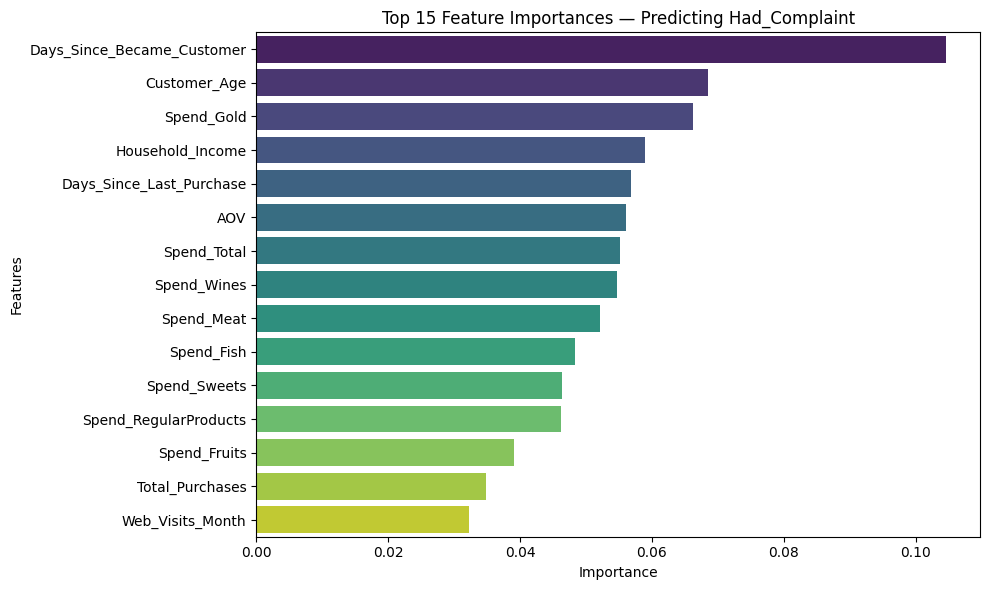

In [34]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------
# 0) Clean DF (make copy)
# -----------------------
drop_cols = [
    "Client_ID", "Total_Campaigns_Accepted",
    "R", "F", "M", "R_score", "F_score", "M_score",
    "segment_definition"
]

df_clean = df.drop(columns=drop_cols, errors="ignore").copy()

# -----------------------
# 1) Features & Target
# -----------------------
target = "Had_Complaint"
X = df_clean.drop(columns=[target])
y = df_clean[target]

# One-hot encode categoricals if needed
X = pd.get_dummies(X, drop_first=True)

# -----------------------
# 2) Train/Test Split
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# -----------------------
# 3) Train Random Forest
# -----------------------
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    class_weight="balanced",  # useful if "Had_Complaint" is imbalanced
    n_jobs=-1
)
rf.fit(X_train, y_train)

# -----------------------
# 4) Evaluate
# -----------------------
y_pred = rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# -----------------------
# 5) Feature Importances
# -----------------------
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.head(15), y=importances.head(15).index, palette="viridis")
plt.title("Top 15 Feature Importances — Predicting Had_Complaint")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

## 📊 Visualizations

This section contains a variety of visualizations created during the exploratory phase of the analysis. 

Some plots were intended to investigate potential patterns or differences between customer segments (such as "At Risk" vs others), helping to uncover areas where deeper insights might be found. These visuals were not always conclusive but served as useful tools for identifying relationships worth exploring further.

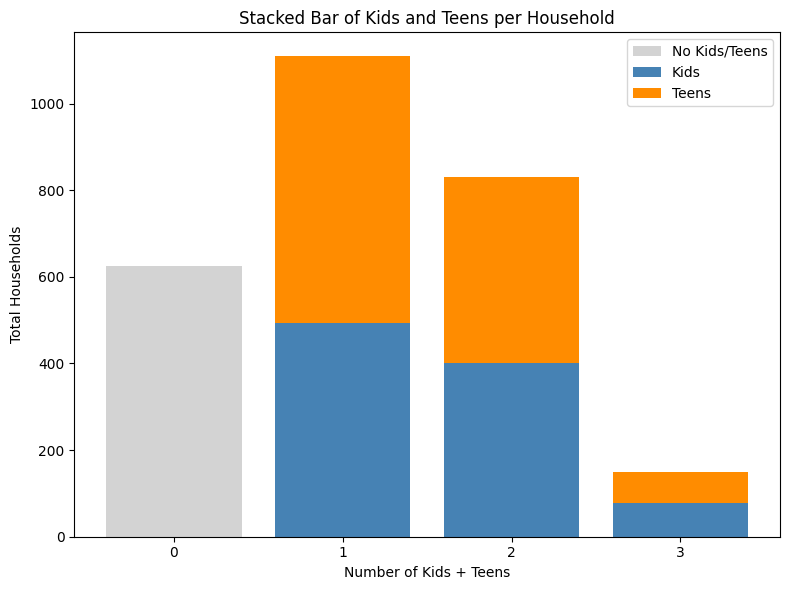

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MultipleLocator  # <— add this

# Example: df has Kids_Count and Teens_Count
df_counts = df[['Kids_Count', 'Teens_Count']].copy()

# Group households into categories by total children (kids + teens)
df_counts['TotalChildren'] = df_counts['Kids_Count'] + df_counts['Teens_Count']

# Count by category
grouped = df_counts.groupby('TotalChildren').sum()[['Kids_Count', 'Teens_Count']]

# Separate out "0 children" households
zero_count = len(df_counts[df_counts['TotalChildren'] == 0])

# Plot
fig, ax = plt.subplots(figsize=(8,6))

# Plot 0 category in light gray
ax.bar(0, zero_count, color="lightgray", label="No Kids/Teens")

# Plot 1+ categories stacked
kids = grouped.loc[grouped.index > 0, 'Kids_Count']
teens = grouped.loc[grouped.index > 0, 'Teens_Count']

ax.bar(kids.index, kids.values, color="steelblue", label="Kids")
ax.bar(teens.index, teens.values, bottom=kids.values, color="darkorange", label="Teens")

# Labels
ax.set_title("Stacked Bar of Kids and Teens per Household")
ax.set_xlabel("Number of Kids + Teens")
ax.set_ylabel("Total Households")
ax.legend()

# Force whole number ticks only
ax.xaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout()
plt.show()

In [36]:
import pandasql as ps

query = """
SELECT 
    'Campaign1' as Campaign, AVG(Customer_Age) as Avg_Age
FROM df
WHERE Campaign1_Response = 1

UNION ALL

SELECT 
    'Campaign2' as Campaign, AVG(Customer_Age) as Avg_Age
FROM df
WHERE Campaign2_Response = 1

UNION ALL

SELECT 
    'Campaign3' as Campaign, AVG(Customer_Age) as Avg_Age
FROM df
WHERE Campaign3_Response = 1

UNION ALL

SELECT 
    'Campaign4' as Campaign, AVG(Customer_Age) as Avg_Age
FROM df
WHERE Campaign4_Response = 1

UNION ALL

SELECT 
    'Campaign5' as Campaign, AVG(Customer_Age) as Avg_Age
FROM df
WHERE Campaign5_Response = 1
;
"""

result = ps.sqldf(query, locals())
print(result)

    Campaign    Avg_Age
0  Campaign1  51.619718
1  Campaign2  51.866667
2  Campaign3  48.552147
3  Campaign4  53.981707
4  Campaign5  50.291925


In [37]:
import pandasql as ps

# Average age of all customers
query = """
SELECT AVG(Customer_Age) AS Avg_Age_All_Customers
FROM df
;
"""

result = ps.sqldf(query, locals())
print(result)

   Avg_Age_All_Customers
0              51.087727


/var/folders/70/jk3vzs_17vj5458mvvyd15zh0000gn/T/ipykernel_3516/1119696914.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


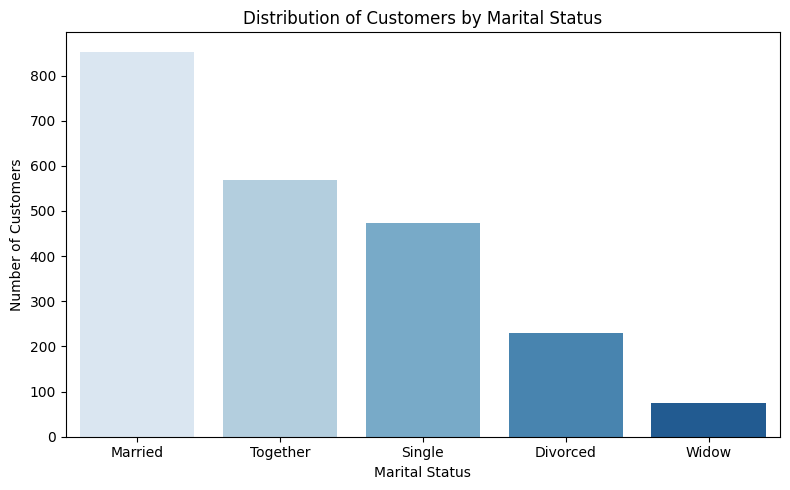

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Marital status columns
marital_cols = [
    "Marital_Single", "Marital_Divorced", "Marital_Married",
    "Marital_Together", "Marital_Widow"
]

# Sum each column to get number of customers per group
marital_counts = df[marital_cols].sum().sort_values(ascending=False)

# Clean names for x-axis
marital_counts.index = marital_counts.index.str.replace("Marital_", "")

# Plot with a blue gradient
plt.figure(figsize=(8, 5))
sns.barplot(
    x=marital_counts.index, 
    y=marital_counts.values, 
    palette=sns.color_palette("Blues", n_colors=len(marital_counts))
)

plt.title("Distribution of Customers by Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()

/var/folders/70/jk3vzs_17vj5458mvvyd15zh0000gn/T/ipykernel_3516/2076235258.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


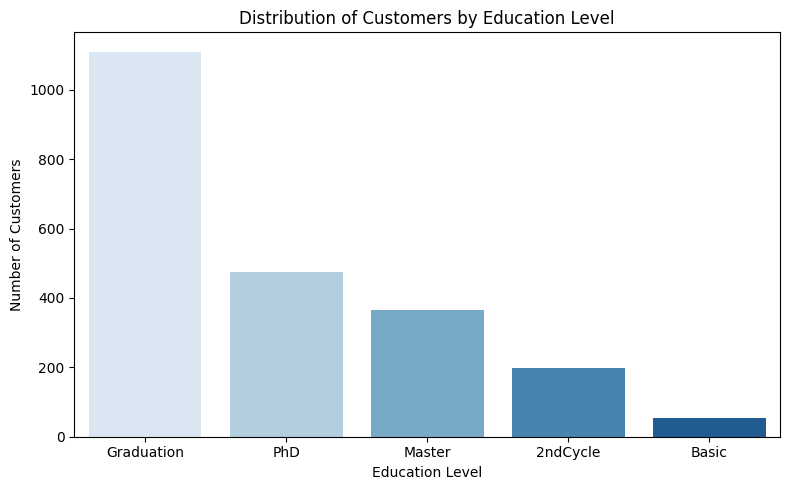

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Education columns
edu_cols = [
    "Edu_Basic", "Edu_2ndCycle", "Edu_Graduation",
    "Edu_Master", "Edu_PhD"
]

# Sum each column to get number of customers per education level
edu_counts = df[edu_cols].sum().sort_values(ascending=False)

# Clean names for x-axis
edu_counts.index = edu_counts.index.str.replace("Edu_", "")

# Plot with a blue gradient
plt.figure(figsize=(8, 5))
sns.barplot(
    x=edu_counts.index,
    y=edu_counts.values,
    palette=sns.color_palette("Blues", n_colors=len(edu_counts))
)

plt.title("Distribution of Customers by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()

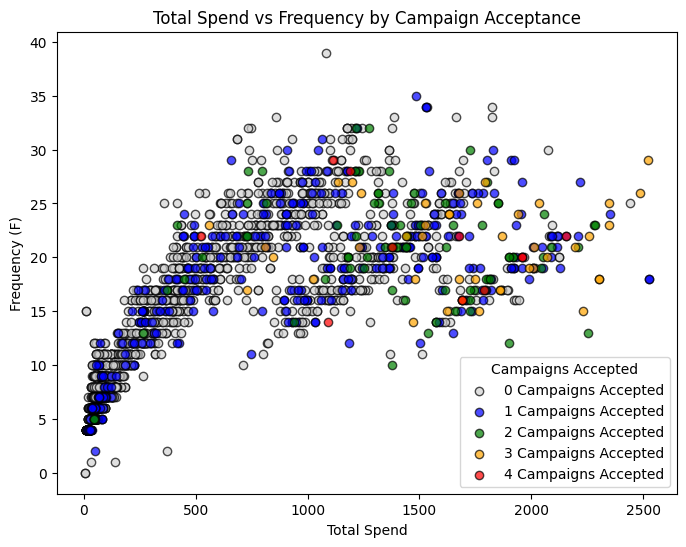

In [41]:
import matplotlib.pyplot as plt

# Define discrete color map (up to 5 campaigns accepted)
colors = {0: "lightgray", 1: "blue", 2: "green", 3: "orange", 4: "red", 5: "purple"}

plt.figure(figsize=(8,6))

# Plot each group separately so colors are discrete
for val, group in df.groupby("Total_Campaigns_Accepted"):
    plt.scatter(
        group["Spend_Total"],
        group["F"],
        label=f"{val} Campaigns Accepted",
        color=colors.get(val, "black"),  # fallback black if any other value
        alpha=0.7,
        edgecolor="k"
    )

# Labels and title
plt.xlabel("Total Spend")
plt.ylabel("Frequency (F)")
plt.title("Total Spend vs Frequency by Campaign Acceptance")
plt.legend(title="Campaigns Accepted")
plt.show()

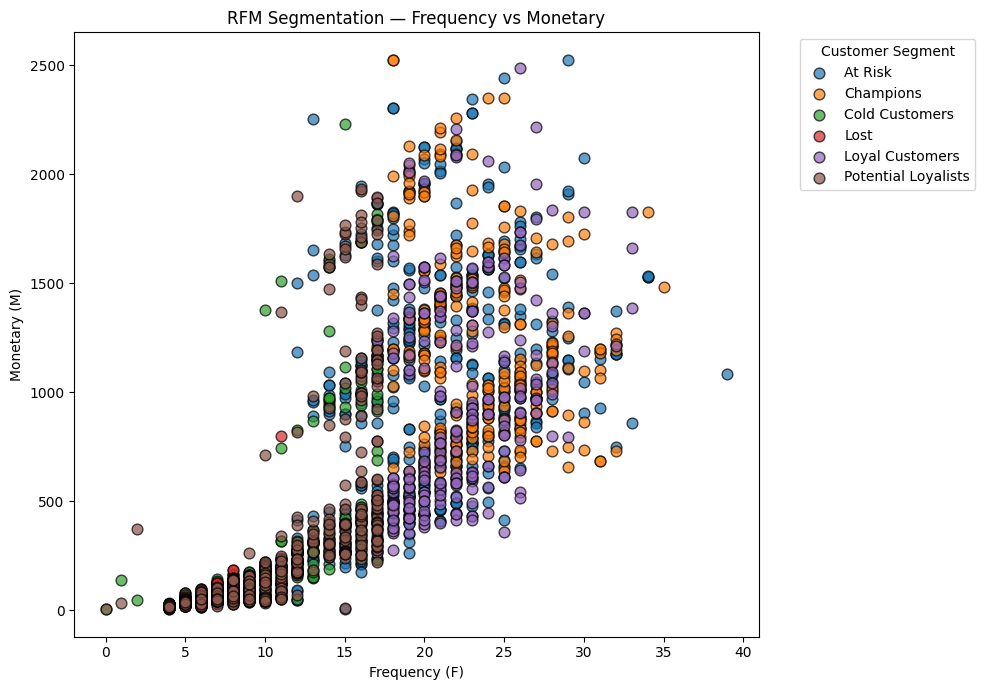

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

# Scatter: Frequency vs Monetary, color by segment
for seg, group in df.groupby("segment_definition"):
    plt.scatter(
        group["F"], 
        group["M"], 
        label=seg, 
        alpha=0.7, 
        s=60, 
        edgecolor="k"
    )

# Labels, title, legend
plt.xlabel("Frequency (F)")
plt.ylabel("Monetary (M)")
plt.title("RFM Segmentation — Frequency vs Monetary")
plt.legend(title="Customer Segment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

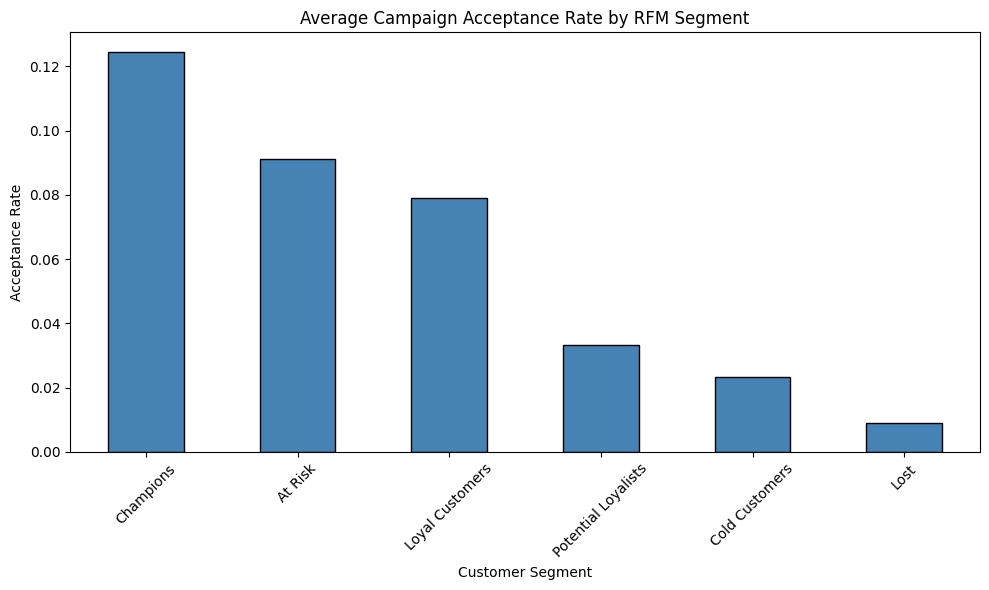

In [43]:
import matplotlib.pyplot as plt

# Example: average campaign response per segment
segment_conv = df.groupby("segment_definition")[["Campaign1_Response","Campaign2_Response",
                                                 "Campaign3_Response","Campaign4_Response",
                                                 "Campaign5_Response"]].mean().mean(axis=1)

segment_conv = segment_conv.sort_values(ascending=False)

plt.figure(figsize=(10,6))
segment_conv.plot(kind="bar", color="steelblue", edgecolor="k")
plt.title("Average Campaign Acceptance Rate by RFM Segment")
plt.ylabel("Acceptance Rate")
plt.xlabel("Customer Segment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/70/jk3vzs_17vj5458mvvyd15zh0000gn/T/ipykernel_3516/683132217.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="segment_definition", y="Spend_Total", data=df, palette="Blues")


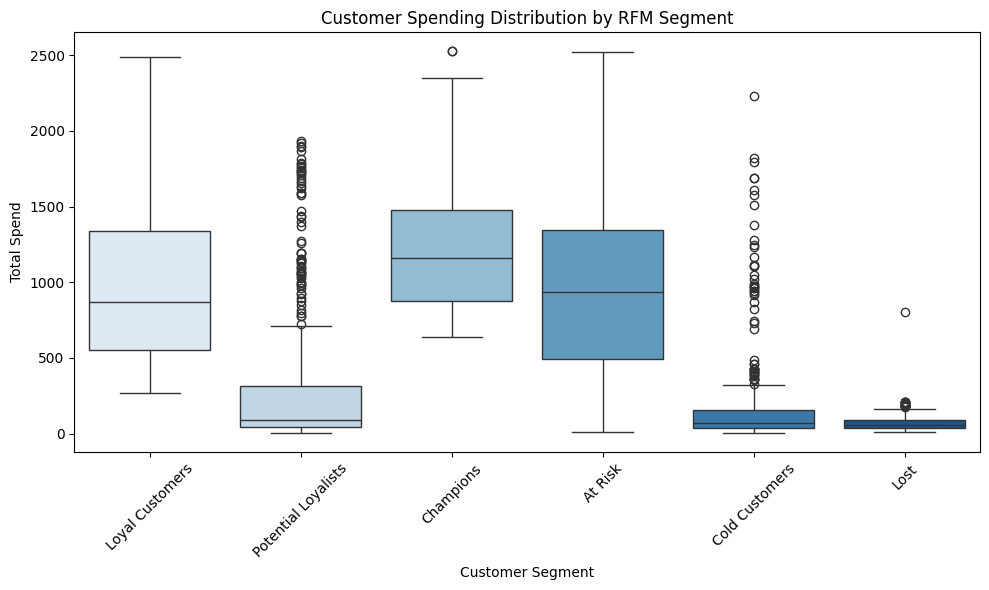

In [44]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(x="segment_definition", y="Spend_Total", data=df, palette="Blues")
plt.title("Customer Spending Distribution by RFM Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Total Spend")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

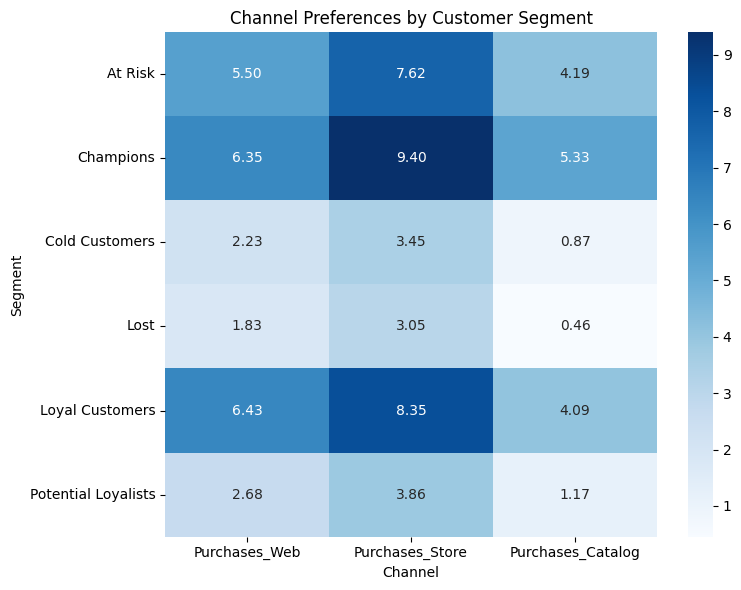

In [45]:
import seaborn as sns

channels = df.groupby("segment_definition")[["Purchases_Web","Purchases_Store","Purchases_Catalog"]].mean()

plt.figure(figsize=(8,6))
sns.heatmap(channels, annot=True, fmt=".2f", cmap="Blues")
plt.title("Channel Preferences by Customer Segment")
plt.xlabel("Channel")
plt.ylabel("Segment")
plt.tight_layout()
plt.show()

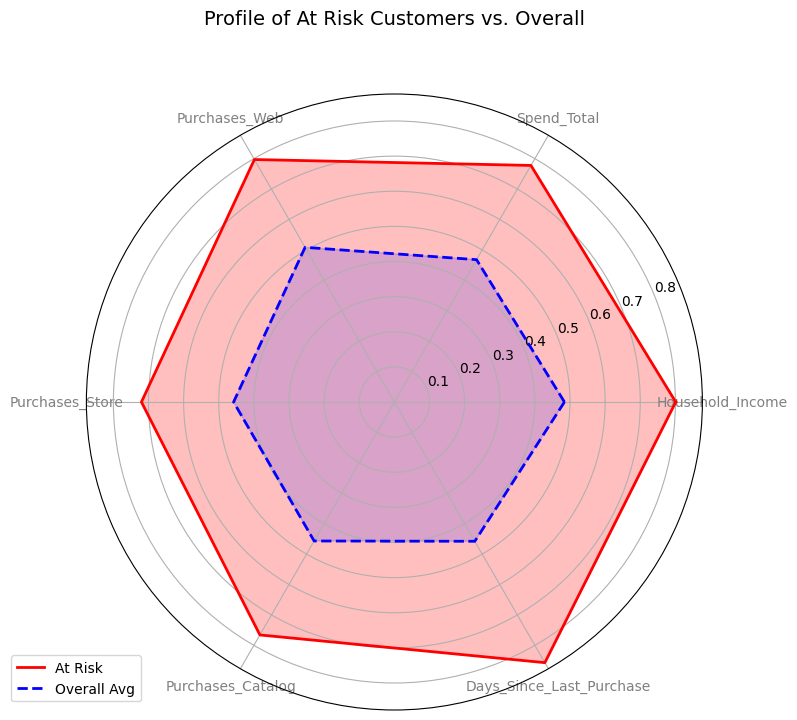

In [ ]:
# Select features to profile
features = ["Household_Income","Spend_Total","Purchases_Web","Purchases_Store","Purchases_Catalog","Days_Since_Last_Purchase"]

# Average per segment
segment_profile = df.groupby("segment_definition")[features].mean()

# Normalize for fair comparison
segment_norm = (segment_profile - segment_profile.min()) / (segment_profile.max() - segment_profile.min())

# Choose At Risk vs others
categories = list(segment_norm.columns)
N = len(categories)

values_atrisk = segment_norm.loc["At Risk"].values.flatten().tolist()
values_avg = segment_norm.mean().values.flatten().tolist()

# Close the loop
values_atrisk += values_atrisk[:1]
values_avg += values_avg[:1]
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Plot
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color='grey', size=10)

ax.plot(angles, values_atrisk, linewidth=2, linestyle='solid', label="At Risk", color="red")
ax.fill(angles, values_atrisk, alpha=0.25, color="red")

ax.plot(angles, values_avg, linewidth=2, linestyle='dashed', label="Overall Avg", color="blue")
ax.fill(angles, values_avg, alpha=0.15, color="blue")

plt.title("Profile of At Risk Customers vs. Overall", size=14, y=1.1)
plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))
plt.show()

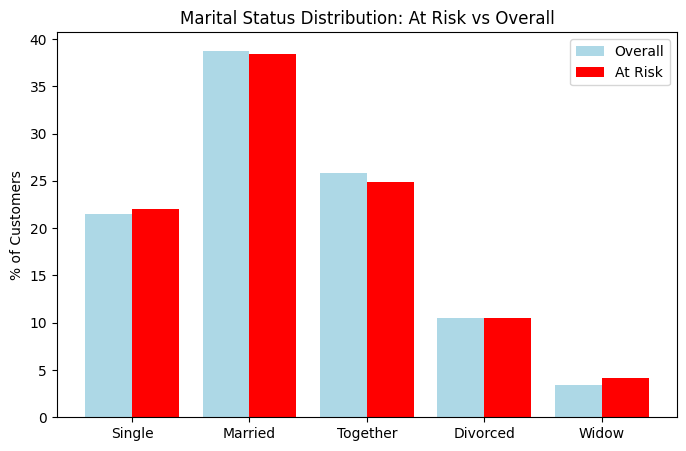

In [49]:
# Example: At Risk vs Overall by Marital Status
import matplotlib.pyplot as plt

# Filter groups
at_risk = df[df['segment_definition'] == 'At Risk']
overall = df.copy()

# Calculate % distributions
marital_cols = ["Marital_Single","Marital_Married","Marital_Together","Marital_Divorced","Marital_Widow"]
at_risk_dist = at_risk[marital_cols].mean() * 100
overall_dist = overall[marital_cols].mean() * 100

# Plot side-by-side bars
fig, ax = plt.subplots(figsize=(8,5))
x = range(len(marital_cols))
ax.bar(x, overall_dist, width=0.4, label="Overall", color="lightblue")
ax.bar([i+0.4 for i in x], at_risk_dist, width=0.4, label="At Risk", color="red")

ax.set_xticks([i+0.2 for i in x])
ax.set_xticklabels([c.replace("Marital_","") for c in marital_cols])
ax.set_ylabel("% of Customers")
ax.set_title("Marital Status Distribution: At Risk vs Overall")
ax.legend()
plt.show()

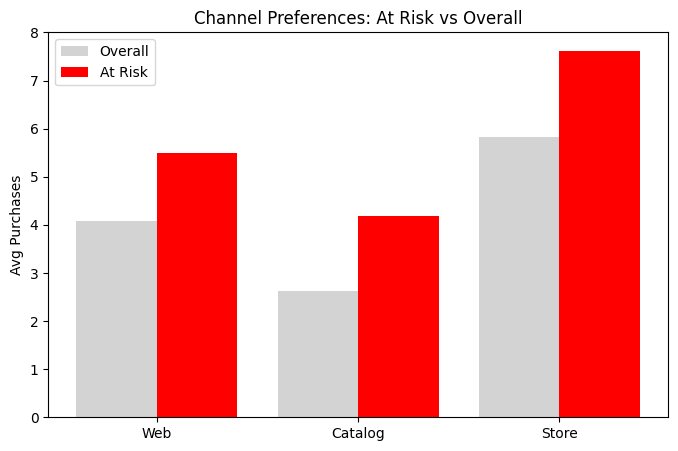

In [50]:
channels = ["Purchases_Web","Purchases_Catalog","Purchases_Store"]

at_risk_channels = at_risk[channels].mean()
overall_channels = overall[channels].mean()

fig, ax = plt.subplots(figsize=(8,5))
x = range(len(channels))
ax.bar(x, overall_channels, width=0.4, label="Overall", color="lightgray")
ax.bar([i+0.4 for i in x], at_risk_channels, width=0.4, label="At Risk", color="red")

ax.set_xticks([i+0.2 for i in x])
ax.set_xticklabels([c.replace("Purchases_","") for c in channels])
ax.set_ylabel("Avg Purchases")
ax.set_title("Channel Preferences: At Risk vs Overall")
ax.legend()
plt.show()

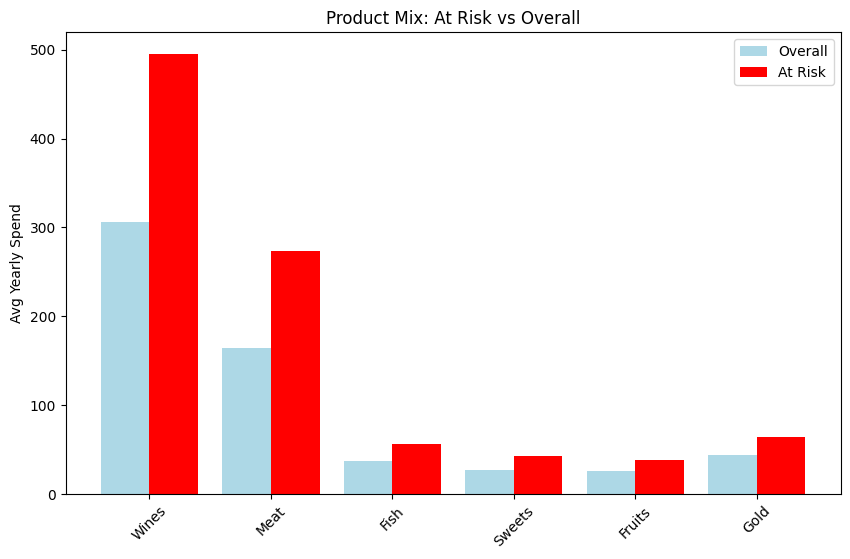

In [51]:
spend_cols = ["Spend_Wines","Spend_Meat","Spend_Fish","Spend_Sweets","Spend_Fruits","Spend_Gold"]

at_risk_spend = at_risk[spend_cols].mean()
overall_spend = overall[spend_cols].mean()

fig, ax = plt.subplots(figsize=(10,6))
x = range(len(spend_cols))
ax.bar(x, overall_spend, width=0.4, label="Overall", color="lightblue")
ax.bar([i+0.4 for i in x], at_risk_spend, width=0.4, label="At Risk", color="red")

ax.set_xticks([i+0.2 for i in x])
ax.set_xticklabels([c.replace("Spend_","") for c in spend_cols], rotation=45)
ax.set_ylabel("Avg Yearly Spend")
ax.set_title("Product Mix: At Risk vs Overall")
ax.legend()
plt.show()

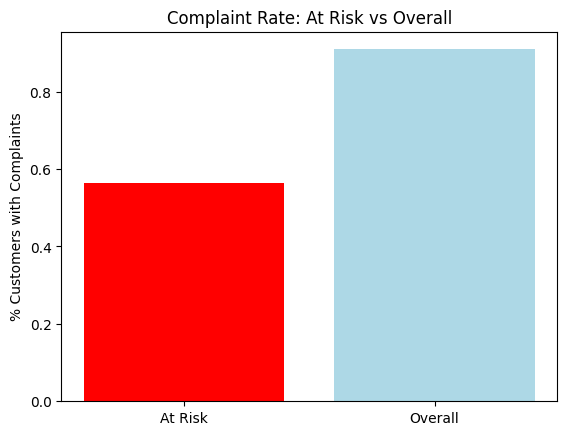

In [52]:
complaints_rate = {
    "At Risk": at_risk['Had_Complaint'].mean() * 100,
    "Overall": overall['Had_Complaint'].mean() * 100
}

plt.bar(complaints_rate.keys(), complaints_rate.values(), color=["red","lightblue"])
plt.ylabel("% Customers with Complaints")
plt.title("Complaint Rate: At Risk vs Overall")
plt.show()

,At Risk (mean),Others (mean)
Kids_Count,0.222222,0.512882
Teens_Count,0.544256,0.494907
No_Kids_Or_Teens,0.397363,0.248652


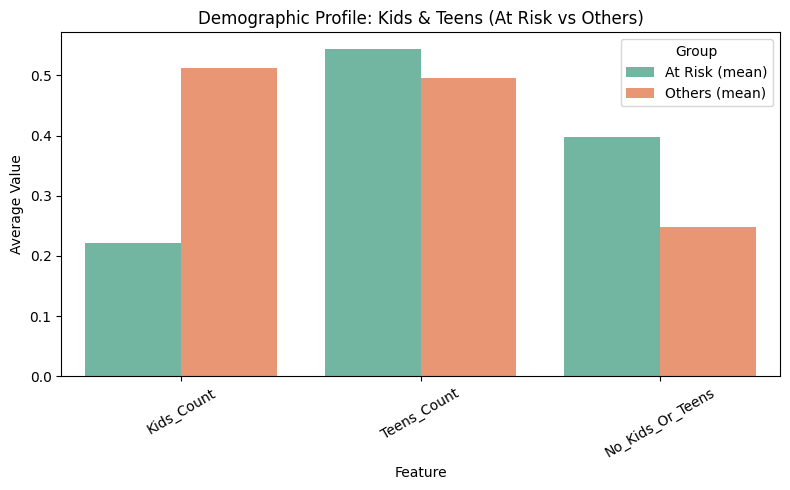

In [63]:


# 1. Split dataset
at_risk = df[df["segment_definition"] == "At Risk"]
others = df[df["segment_definition"] != "At Risk"]

# 2. Create 'No_Kids_Or_Teens' flag
df["No_Kids_Or_Teens"] = ((df["Kids_Count"] == 0) & (df["Teens_Count"] == 0)).astype(int)
at_risk = df[df["segment_definition"] == "At Risk"]
others = df[df["segment_definition"] != "At Risk"]

# 3. Define features to include
demo_features = ["Kids_Count", "Teens_Count", "No_Kids_Or_Teens"]

# 4. Summary stats
summary = pd.DataFrame({
    "At Risk (mean)": at_risk[demo_features].mean(),
    "Others (mean)": others[demo_features].mean()
})

display(summary)

# 5. Visualization
summary_melted = summary.reset_index().melt(id_vars="index", 
                                            var_name="Group", 
                                            value_name="Average")

plt.figure(figsize=(8,5))
sns.barplot(data=summary_melted, x="index", y="Average", hue="Group", palette="Set2")
plt.title("Demographic Profile: Kids & Teens (At Risk vs Others)")
plt.xlabel("Feature")
plt.ylabel("Average Value")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

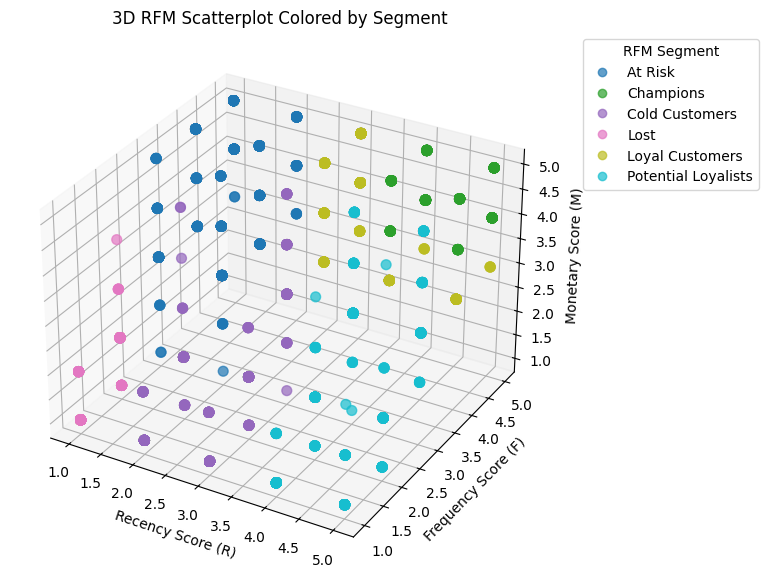

In [ ]:

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# 3D scatterplot of R vs F vs M, colored by segment_definition
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create scatter
scatter = ax.scatter(
    df["R_score"], 
    df["F_score"], 
    df["M_score"],
    c=df["segment_definition"].astype("category").cat.codes,  # map segments to colors
    cmap="tab10",  # 10 discrete colors
    alpha=0.7,
    s=50
)

# Axis labels
ax.set_xlabel("Recency Score (R)")
ax.set_ylabel("Frequency Score (F)")
ax.set_zlabel("Monetary Score (M)")
ax.set_title("3D RFM Scatterplot Colored by Segment")

# Legend (map back category codes to names)
handles, _ = scatter.legend_elements(prop="colors")
labels = df["segment_definition"].astype("category").cat.categories
ax.legend(handles, labels, title="RFM Segment", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()

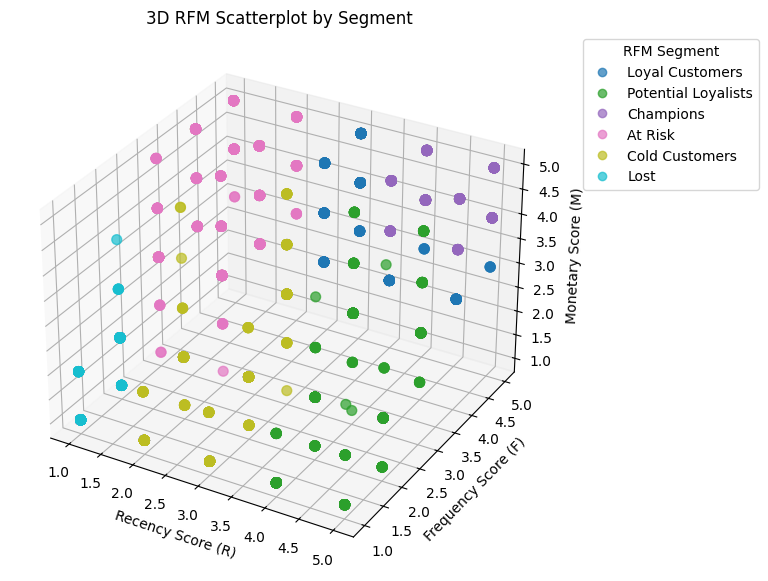

In [ ]:

from mpl_toolkits.mplot3d import Axes3D

# Drop rows with missing RFM scores or segment
rfm_df = df.dropna(subset=["R_score", "F_score", "M_score", "segment_definition"]).copy()

# Encode categories manually
segment_codes, segment_labels = pd.factorize(rfm_df["segment_definition"])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot
scatter = ax.scatter(
    rfm_df["R_score"],
    rfm_df["F_score"],
    rfm_df["M_score"],
    c=segment_codes,
    cmap="tab10",
    alpha=0.7,
    s=50
)

# Axis labels
ax.set_xlabel("Recency Score (R)")
ax.set_ylabel("Frequency Score (F)")
ax.set_zlabel("Monetary Score (M)")
ax.set_title("3D RFM Scatterplot by Segment")

# Legend
handles, _ = scatter.legend_elements(prop="colors")
ax.legend(handles, segment_labels, title="RFM Segment", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()

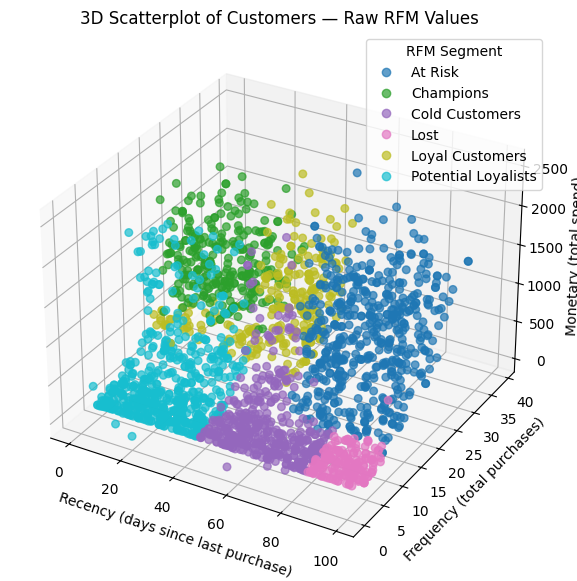

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Create figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using raw values
scatter = ax.scatter(
    df["R"], 
    df["F"], 
    df["M"], 
    c=df["segment_definition"].astype("category").cat.codes,  # color by RFM segment
    cmap="tab10", 
    s=30, alpha=0.7
)

# Labels
ax.set_xlabel("Recency (days since last purchase)")
ax.set_ylabel("Frequency (total purchases)")
ax.set_zlabel("Monetary (total spend)")
ax.set_title("3D Scatterplot of Customers — Raw RFM Values")

# Legend
handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
ax.legend(handles, df["segment_definition"].astype("category").cat.categories, title="RFM Segment")

plt.show()

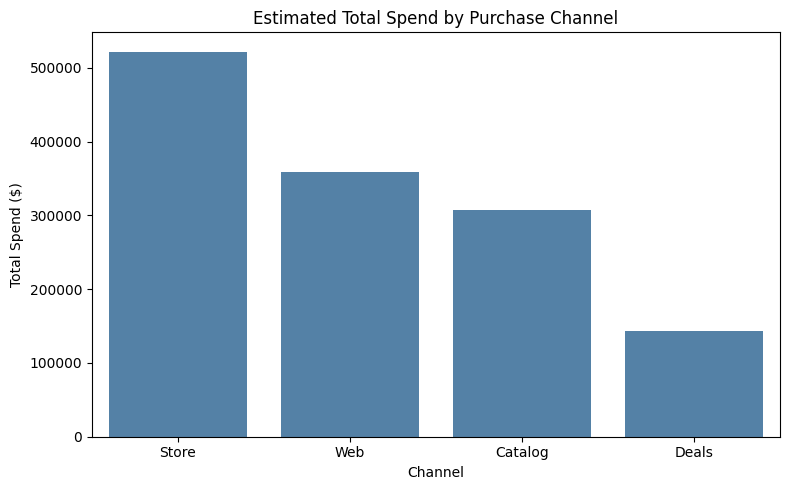

In [62]:
df['Spend_Total'] = df['Spend_Total']  # already exists

# Define channel columns
channel_columns = {
    'Store': 'Purchases_Store',
    'Web': 'Purchases_Web',
    'Catalog': 'Purchases_Catalog',
    'Deals': 'Purchases_Deals'
}

# Estimate total spend per channel using proportional allocation
total_channel_spend = {}

df['Total_Channel_Purchases'] = df[list(channel_columns.values())].sum(axis=1)

for channel, col in channel_columns.items():
    proportion = df[col] / df['Total_Channel_Purchases']
    estimated_spend = (proportion * df['Spend_Total']).fillna(0)
    total_channel_spend[channel] = estimated_spend.sum()

# Convert to DataFrame
channel_spend_df = pd.DataFrame.from_dict(total_channel_spend, orient='index', columns=['Total_Spend']).reset_index()
channel_spend_df.columns = ['Channel', 'Total_Spend']

# Plot with blue bars
plt.figure(figsize=(8,5))
sns.barplot(data=channel_spend_df, x='Channel', y='Total_Spend', color='steelblue')
plt.title('Estimated Total Spend by Purchase Channel')
plt.xlabel('Channel')
plt.ylabel('Total Spend ($)')
plt.tight_layout()
plt.show()